In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3312053, 828)
(3312053, 8)
validation
(477757, 828)
(477757, 8)
test
(427942, 828)
(427942, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/332 [..............................] - ETA: 7:38 - loss: 2.4565 - STD: 0.1251 - MAE: 0.2201

  4/332 [..............................] - ETA: 5s - loss: 2.2056 - STD: 0.0644 - MAE: 0.2185  

  7/332 [..............................] - ETA: 5s - loss: 2.1470 - STD: 0.0567 - MAE: 0.2175

 10/332 [..............................] - ETA: 5s - loss: 2.1307 - STD: 0.0559 - MAE: 0.2170

 13/332 [>.............................] - ETA: 5s - loss: 2.1202 - STD: 0.0545 - MAE: 0.2167

 16/332 [>.............................] - ETA: 5s - loss: 2.1105 - STD: 0.0526 - MAE: 0.2166

 19/332 [>.............................] - ETA: 5s - loss: 2.1017 - STD: 0.0498 - MAE: 0.2166

 22/332 [>.............................] - ETA: 5s - loss: 2.0952 - STD: 0.0470 - MAE: 0.2167

 25/332 [=>............................] - ETA: 5s - loss: 2.0906 - STD: 0.0447 - MAE: 0.2167

 28/332 [=>............................] - ETA: 5s - loss: 2.0869 - STD: 0.0429 - MAE: 0.2168

 31/332 [=>............................] - ETA: 5s - loss: 2.0834 - STD: 0.0415 - MAE: 0.2168

 34/332 [==>...........................] - ETA: 5s - loss: 2.0802 - STD: 0.0406 - MAE: 0.2168

 37/332 [==>...........................] - ETA: 5s - loss: 2.0772 - STD: 0.0400 - MAE: 0.2167

 40/332 [==>...........................] - ETA: 5s - loss: 2.0745 - STD: 0.0396 - MAE: 0.2167

 43/332 [==>...........................] - ETA: 5s - loss: 2.0716 - STD: 0.0393 - MAE: 0.2166

 46/332 [===>..........................] - ETA: 5s - loss: 2.0684 - STD: 0.0390 - MAE: 0.2166

 49/332 [===>..........................] - ETA: 5s - loss: 2.0645 - STD: 0.0388 - MAE: 0.2165

 52/332 [===>..........................] - ETA: 5s - loss: 2.0602 - STD: 0.0387 - MAE: 0.2163

 55/332 [===>..........................] - ETA: 4s - loss: 2.0550 - STD: 0.0390 - MAE: 0.2161

 58/332 [====>.........................] - ETA: 4s - loss: 2.0491 - STD: 0.0396 - MAE: 0.2159

 62/332 [====>.........................] - ETA: 4s - loss: 2.0403 - STD: 0.0409 - MAE: 0.2155

 65/332 [====>.........................] - ETA: 4s - loss: 2.0333 - STD: 0.0420 - MAE: 0.2152

 68/332 [=====>........................] - ETA: 4s - loss: 2.0263 - STD: 0.0432 - MAE: 0.2148

 71/332 [=====>........................] - ETA: 4s - loss: 2.0189 - STD: 0.0445 - MAE: 0.2144

 74/332 [=====>........................] - ETA: 4s - loss: 2.0113 - STD: 0.0458 - MAE: 0.2141

 77/332 [=====>........................] - ETA: 4s - loss: 2.0035 - STD: 0.0471 - MAE: 0.2137

 80/332 [======>.......................] - ETA: 4s - loss: 1.9957 - STD: 0.0484 - MAE: 0.2133

 83/332 [======>.......................] - ETA: 4s - loss: 1.9881 - STD: 0.0497 - MAE: 0.2129

 86/332 [======>.......................] - ETA: 4s - loss: 1.9803 - STD: 0.0509 - MAE: 0.2125

 89/332 [=======>......................] - ETA: 4s - loss: 1.9727 - STD: 0.0522 - MAE: 0.2121

 93/332 [=======>......................] - ETA: 4s - loss: 1.9618 - STD: 0.0539 - MAE: 0.2115

 97/332 [=======>......................] - ETA: 4s - loss: 1.9508 - STD: 0.0556 - MAE: 0.2109

100/332 [========>.....................] - ETA: 4s - loss: 1.9417 - STD: 0.0569 - MAE: 0.2104

103/332 [========>.....................] - ETA: 4s - loss: 1.9322 - STD: 0.0582 - MAE: 0.2099

106/332 [========>.....................] - ETA: 4s - loss: 1.9227 - STD: 0.0597 - MAE: 0.2093

109/332 [========>.....................] - ETA: 3s - loss: 1.9128 - STD: 0.0612 - MAE: 0.2087

113/332 [=========>....................] - ETA: 3s - loss: 1.8997 - STD: 0.0633 - MAE: 0.2079

116/332 [=========>....................] - ETA: 3s - loss: 1.8902 - STD: 0.0649 - MAE: 0.2073

120/332 [=========>....................] - ETA: 3s - loss: 1.8779 - STD: 0.0671 - MAE: 0.2065

123/332 [==========>...................] - ETA: 3s - loss: 1.8690 - STD: 0.0686 - MAE: 0.2059

126/332 [==========>...................] - ETA: 3s - loss: 1.8605 - STD: 0.0702 - MAE: 0.2054

129/332 [==========>...................] - ETA: 3s - loss: 1.8517 - STD: 0.0716 - MAE: 0.2048

132/332 [==========>...................] - ETA: 3s - loss: 1.8435 - STD: 0.0730 - MAE: 0.2042

135/332 [===========>..................] - ETA: 3s - loss: 1.8354 - STD: 0.0743 - MAE: 0.2037

138/332 [===========>..................] - ETA: 3s - loss: 1.8276 - STD: 0.0757 - MAE: 0.2032

142/332 [===========>..................] - ETA: 3s - loss: 1.8177 - STD: 0.0774 - MAE: 0.2025

145/332 [============>.................] - ETA: 3s - loss: 1.8104 - STD: 0.0786 - MAE: 0.2020

148/332 [============>.................] - ETA: 3s - loss: 1.8033 - STD: 0.0798 - MAE: 0.2015

151/332 [============>.................] - ETA: 3s - loss: 1.7966 - STD: 0.0810 - MAE: 0.2011

154/332 [============>.................] - ETA: 3s - loss: 1.7899 - STD: 0.0821 - MAE: 0.2006

157/332 [=============>................] - ETA: 3s - loss: 1.7832 - STD: 0.0832 - MAE: 0.2002

160/332 [=============>................] - ETA: 3s - loss: 1.7768 - STD: 0.0843 - MAE: 0.1997

163/332 [=============>................] - ETA: 2s - loss: 1.7704 - STD: 0.0853 - MAE: 0.1993

166/332 [==============>...............] - ETA: 2s - loss: 1.7644 - STD: 0.0863 - MAE: 0.1989

169/332 [==============>...............] - ETA: 2s - loss: 1.7583 - STD: 0.0873 - MAE: 0.1984

172/332 [==============>...............] - ETA: 2s - loss: 1.7525 - STD: 0.0883 - MAE: 0.1980

175/332 [==============>...............] - ETA: 2s - loss: 1.7465 - STD: 0.0893 - MAE: 0.1976

178/332 [===============>..............] - ETA: 2s - loss: 1.7406 - STD: 0.0903 - MAE: 0.1971

181/332 [===============>..............] - ETA: 2s - loss: 1.7349 - STD: 0.0912 - MAE: 0.1967

184/332 [===============>..............] - ETA: 2s - loss: 1.7295 - STD: 0.0922 - MAE: 0.1963

187/332 [===============>..............] - ETA: 2s - loss: 1.7240 - STD: 0.0931 - MAE: 0.1959

190/332 [================>.............] - ETA: 2s - loss: 1.7185 - STD: 0.0940 - MAE: 0.1955

193/332 [================>.............] - ETA: 2s - loss: 1.7132 - STD: 0.0950 - MAE: 0.1951

196/332 [================>.............] - ETA: 2s - loss: 1.7080 - STD: 0.0959 - MAE: 0.1947

199/332 [================>.............] - ETA: 2s - loss: 1.7029 - STD: 0.0967 - MAE: 0.1943

202/332 [=================>............] - ETA: 2s - loss: 1.6978 - STD: 0.0976 - MAE: 0.1939

205/332 [=================>............] - ETA: 2s - loss: 1.6931 - STD: 0.0985 - MAE: 0.1935

209/332 [=================>............] - ETA: 2s - loss: 1.6867 - STD: 0.0996 - MAE: 0.1930

213/332 [==================>...........] - ETA: 2s - loss: 1.6804 - STD: 0.1007 - MAE: 0.1925

216/332 [==================>...........] - ETA: 2s - loss: 1.6758 - STD: 0.1015 - MAE: 0.1921

219/332 [==================>...........] - ETA: 1s - loss: 1.6713 - STD: 0.1024 - MAE: 0.1917

222/332 [===================>..........] - ETA: 1s - loss: 1.6668 - STD: 0.1031 - MAE: 0.1914

225/332 [===================>..........] - ETA: 1s - loss: 1.6624 - STD: 0.1039 - MAE: 0.1910

228/332 [===================>..........] - ETA: 1s - loss: 1.6581 - STD: 0.1046 - MAE: 0.1907

231/332 [===================>..........] - ETA: 1s - loss: 1.6540 - STD: 0.1054 - MAE: 0.1903

234/332 [====================>.........] - ETA: 1s - loss: 1.6498 - STD: 0.1061 - MAE: 0.1900

237/332 [====================>.........] - ETA: 1s - loss: 1.6458 - STD: 0.1068 - MAE: 0.1897

240/332 [====================>.........] - ETA: 1s - loss: 1.6419 - STD: 0.1075 - MAE: 0.1893

243/332 [====================>.........] - ETA: 1s - loss: 1.6380 - STD: 0.1082 - MAE: 0.1890

247/332 [=====================>........] - ETA: 1s - loss: 1.6328 - STD: 0.1091 - MAE: 0.1886

250/332 [=====================>........] - ETA: 1s - loss: 1.6290 - STD: 0.1098 - MAE: 0.1883

253/332 [=====================>........] - ETA: 1s - loss: 1.6253 - STD: 0.1105 - MAE: 0.1880

256/332 [======================>.......] - ETA: 1s - loss: 1.6217 - STD: 0.1111 - MAE: 0.1877

259/332 [======================>.......] - ETA: 1s - loss: 1.6179 - STD: 0.1118 - MAE: 0.1874

262/332 [======================>.......] - ETA: 1s - loss: 1.6143 - STD: 0.1124 - MAE: 0.1871

265/332 [======================>.......] - ETA: 1s - loss: 1.6106 - STD: 0.1130 - MAE: 0.1868

268/332 [=======================>......] - ETA: 1s - loss: 1.6070 - STD: 0.1136 - MAE: 0.1865

271/332 [=======================>......] - ETA: 1s - loss: 1.6035 - STD: 0.1142 - MAE: 0.1862

275/332 [=======================>......] - ETA: 0s - loss: 1.5988 - STD: 0.1150 - MAE: 0.1858

278/332 [========================>.....] - ETA: 0s - loss: 1.5954 - STD: 0.1156 - MAE: 0.1855

281/332 [========================>.....] - ETA: 0s - loss: 1.5920 - STD: 0.1162 - MAE: 0.1852

284/332 [========================>.....] - ETA: 0s - loss: 1.5886 - STD: 0.1167 - MAE: 0.1849

287/332 [========================>.....] - ETA: 0s - loss: 1.5853 - STD: 0.1173 - MAE: 0.1846

291/332 [=========================>....] - ETA: 0s - loss: 1.5809 - STD: 0.1181 - MAE: 0.1843

294/332 [=========================>....] - ETA: 0s - loss: 1.5779 - STD: 0.1186 - MAE: 0.1840

297/332 [=========================>....] - ETA: 0s - loss: 1.5748 - STD: 0.1192 - MAE: 0.1837

301/332 [==========================>...] - ETA: 0s - loss: 1.5706 - STD: 0.1199 - MAE: 0.1834

304/332 [==========================>...] - ETA: 0s - loss: 1.5675 - STD: 0.1204 - MAE: 0.1831

305/332 [==========================>...] - ETA: 0s - loss: 1.5673 - STD: 0.1206 - MAE: 0.1830

308/332 [==========================>...] - ETA: 0s - loss: 1.5643 - STD: 0.1211 - MAE: 0.1828

311/332 [===========================>..] - ETA: 0s - loss: 1.5612 - STD: 0.1216 - MAE: 0.1825

314/332 [===========================>..] - ETA: 0s - loss: 1.5582 - STD: 0.1221 - MAE: 0.1823

317/332 [===========================>..] - ETA: 0s - loss: 1.5552 - STD: 0.1226 - MAE: 0.1820

320/332 [===========================>..] - ETA: 0s - loss: 1.5524 - STD: 0.1231 - MAE: 0.1818

323/332 [============================>.] - ETA: 0s - loss: 1.5497 - STD: 0.1236 - MAE: 0.1815

326/332 [============================>.] - ETA: 0s - loss: 1.5471 - STD: 0.1241 - MAE: 0.1813

330/332 [============================>.] - ETA: 0s - loss: 1.5433 - STD: 0.1247 - MAE: 0.1810

332/332 [==============================] - 9s 23ms/step - loss: 1.5415 - STD: 0.1250 - MAE: 0.1808 - val_loss: 1.3022 - val_STD: 0.1760 - val_MAE: 0.1566


Epoch 2/10000


  1/332 [..............................] - ETA: 16s - loss: 1.2437 - STD: 0.1746 - MAE: 0.1560

  4/332 [..............................] - ETA: 7s - loss: 1.2340 - STD: 0.1766 - MAE: 0.1546 

  7/332 [..............................] - ETA: 7s - loss: 1.2327 - STD: 0.1764 - MAE: 0.1545

 10/332 [..............................] - ETA: 6s - loss: 1.2328 - STD: 0.1764 - MAE: 0.1545

 13/332 [>.............................] - ETA: 6s - loss: 1.2318 - STD: 0.1767 - MAE: 0.1544

 16/332 [>.............................] - ETA: 6s - loss: 1.2305 - STD: 0.1770 - MAE: 0.1542

 19/332 [>.............................] - ETA: 6s - loss: 1.2302 - STD: 0.1771 - MAE: 0.1542

 23/332 [=>............................] - ETA: 5s - loss: 1.2308 - STD: 0.1771 - MAE: 0.1542

 26/332 [=>............................] - ETA: 5s - loss: 1.2288 - STD: 0.1773 - MAE: 0.1541

 29/332 [=>............................] - ETA: 5s - loss: 1.2277 - STD: 0.1774 - MAE: 0.1539

 32/332 [=>............................] - ETA: 5s - loss: 1.2286 - STD: 0.1777 - MAE: 0.1539

 35/332 [==>...........................] - ETA: 5s - loss: 1.2285 - STD: 0.1779 - MAE: 0.1538

 39/332 [==>...........................] - ETA: 5s - loss: 1.2286 - STD: 0.1781 - MAE: 0.1537

 43/332 [==>...........................] - ETA: 5s - loss: 1.2283 - STD: 0.1784 - MAE: 0.1536

 47/332 [===>..........................] - ETA: 5s - loss: 1.2265 - STD: 0.1785 - MAE: 0.1535

 50/332 [===>..........................] - ETA: 5s - loss: 1.2262 - STD: 0.1785 - MAE: 0.1535

 53/332 [===>..........................] - ETA: 5s - loss: 1.2251 - STD: 0.1786 - MAE: 0.1534

 57/332 [====>.........................] - ETA: 4s - loss: 1.2241 - STD: 0.1787 - MAE: 0.1533

 60/332 [====>.........................] - ETA: 4s - loss: 1.2231 - STD: 0.1789 - MAE: 0.1532

 63/332 [====>.........................] - ETA: 4s - loss: 1.2220 - STD: 0.1790 - MAE: 0.1531

 66/332 [====>.........................] - ETA: 4s - loss: 1.2209 - STD: 0.1791 - MAE: 0.1530

 69/332 [=====>........................] - ETA: 4s - loss: 1.2198 - STD: 0.1792 - MAE: 0.1529

 72/332 [=====>........................] - ETA: 4s - loss: 1.2183 - STD: 0.1793 - MAE: 0.1528

 75/332 [=====>........................] - ETA: 4s - loss: 1.2174 - STD: 0.1795 - MAE: 0.1527

 78/332 [======>.......................] - ETA: 4s - loss: 1.2165 - STD: 0.1796 - MAE: 0.1526

 81/332 [======>.......................] - ETA: 4s - loss: 1.2160 - STD: 0.1797 - MAE: 0.1526

 84/332 [======>.......................] - ETA: 4s - loss: 1.2151 - STD: 0.1799 - MAE: 0.1525

 88/332 [======>.......................] - ETA: 4s - loss: 1.2134 - STD: 0.1801 - MAE: 0.1523

 92/332 [=======>......................] - ETA: 4s - loss: 1.2119 - STD: 0.1802 - MAE: 0.1522

 95/332 [=======>......................] - ETA: 4s - loss: 1.2109 - STD: 0.1803 - MAE: 0.1521

 98/332 [=======>......................] - ETA: 4s - loss: 1.2098 - STD: 0.1804 - MAE: 0.1520

101/332 [========>.....................] - ETA: 4s - loss: 1.2094 - STD: 0.1805 - MAE: 0.1519

104/332 [========>.....................] - ETA: 4s - loss: 1.2086 - STD: 0.1807 - MAE: 0.1518

107/332 [========>.....................] - ETA: 3s - loss: 1.2075 - STD: 0.1808 - MAE: 0.1517

111/332 [=========>....................] - ETA: 3s - loss: 1.2065 - STD: 0.1810 - MAE: 0.1516

114/332 [=========>....................] - ETA: 3s - loss: 1.2053 - STD: 0.1811 - MAE: 0.1515

117/332 [=========>....................] - ETA: 3s - loss: 1.2048 - STD: 0.1813 - MAE: 0.1515

120/332 [=========>....................] - ETA: 3s - loss: 1.2044 - STD: 0.1814 - MAE: 0.1514

123/332 [==========>...................] - ETA: 3s - loss: 1.2038 - STD: 0.1815 - MAE: 0.1513

126/332 [==========>...................] - ETA: 3s - loss: 1.2031 - STD: 0.1816 - MAE: 0.1513

130/332 [==========>...................] - ETA: 3s - loss: 1.2021 - STD: 0.1817 - MAE: 0.1512

133/332 [===========>..................] - ETA: 3s - loss: 1.2015 - STD: 0.1818 - MAE: 0.1511

136/332 [===========>..................] - ETA: 3s - loss: 1.2006 - STD: 0.1819 - MAE: 0.1510

139/332 [===========>..................] - ETA: 3s - loss: 1.2000 - STD: 0.1820 - MAE: 0.1509

142/332 [===========>..................] - ETA: 3s - loss: 1.1993 - STD: 0.1822 - MAE: 0.1509

145/332 [============>.................] - ETA: 3s - loss: 1.1986 - STD: 0.1823 - MAE: 0.1508

149/332 [============>.................] - ETA: 3s - loss: 1.1972 - STD: 0.1824 - MAE: 0.1507

152/332 [============>.................] - ETA: 3s - loss: 1.1965 - STD: 0.1825 - MAE: 0.1506

155/332 [=============>................] - ETA: 3s - loss: 1.1957 - STD: 0.1826 - MAE: 0.1505

159/332 [=============>................] - ETA: 3s - loss: 1.1947 - STD: 0.1828 - MAE: 0.1504

162/332 [=============>................] - ETA: 2s - loss: 1.1941 - STD: 0.1828 - MAE: 0.1504

165/332 [=============>................] - ETA: 2s - loss: 1.1931 - STD: 0.1829 - MAE: 0.1503

168/332 [==============>...............] - ETA: 2s - loss: 1.1924 - STD: 0.1830 - MAE: 0.1502

171/332 [==============>...............] - ETA: 2s - loss: 1.1919 - STD: 0.1831 - MAE: 0.1502

174/332 [==============>...............] - ETA: 2s - loss: 1.1916 - STD: 0.1833 - MAE: 0.1501

177/332 [==============>...............] - ETA: 2s - loss: 1.1914 - STD: 0.1833 - MAE: 0.1501

180/332 [===============>..............] - ETA: 2s - loss: 1.1908 - STD: 0.1834 - MAE: 0.1500

183/332 [===============>..............] - ETA: 2s - loss: 1.1901 - STD: 0.1835 - MAE: 0.1500

186/332 [===============>..............] - ETA: 2s - loss: 1.1897 - STD: 0.1836 - MAE: 0.1499

189/332 [================>.............] - ETA: 2s - loss: 1.1890 - STD: 0.1837 - MAE: 0.1498

192/332 [================>.............] - ETA: 2s - loss: 1.1883 - STD: 0.1837 - MAE: 0.1498

196/332 [================>.............] - ETA: 2s - loss: 1.1873 - STD: 0.1839 - MAE: 0.1497

200/332 [=================>............] - ETA: 2s - loss: 1.1865 - STD: 0.1840 - MAE: 0.1496

203/332 [=================>............] - ETA: 2s - loss: 1.1859 - STD: 0.1841 - MAE: 0.1495

206/332 [=================>............] - ETA: 2s - loss: 1.1852 - STD: 0.1842 - MAE: 0.1494

209/332 [=================>............] - ETA: 2s - loss: 1.1846 - STD: 0.1843 - MAE: 0.1494

212/332 [==================>...........] - ETA: 2s - loss: 1.1841 - STD: 0.1844 - MAE: 0.1493

215/332 [==================>...........] - ETA: 2s - loss: 1.1835 - STD: 0.1845 - MAE: 0.1493

218/332 [==================>...........] - ETA: 1s - loss: 1.1830 - STD: 0.1846 - MAE: 0.1492

222/332 [===================>..........] - ETA: 1s - loss: 1.1822 - STD: 0.1847 - MAE: 0.1491

225/332 [===================>..........] - ETA: 1s - loss: 1.1818 - STD: 0.1848 - MAE: 0.1491

228/332 [===================>..........] - ETA: 1s - loss: 1.1812 - STD: 0.1849 - MAE: 0.1490

232/332 [===================>..........] - ETA: 1s - loss: 1.1803 - STD: 0.1850 - MAE: 0.1489

236/332 [====================>.........] - ETA: 1s - loss: 1.1793 - STD: 0.1851 - MAE: 0.1488

239/332 [====================>.........] - ETA: 1s - loss: 1.1786 - STD: 0.1852 - MAE: 0.1488

242/332 [====================>.........] - ETA: 1s - loss: 1.1779 - STD: 0.1852 - MAE: 0.1487

245/332 [=====================>........] - ETA: 1s - loss: 1.1773 - STD: 0.1853 - MAE: 0.1487

248/332 [=====================>........] - ETA: 1s - loss: 1.1767 - STD: 0.1854 - MAE: 0.1486

251/332 [=====================>........] - ETA: 1s - loss: 1.1760 - STD: 0.1855 - MAE: 0.1485

254/332 [=====================>........] - ETA: 1s - loss: 1.1754 - STD: 0.1855 - MAE: 0.1485

257/332 [======================>.......] - ETA: 1s - loss: 1.1748 - STD: 0.1856 - MAE: 0.1484

260/332 [======================>.......] - ETA: 1s - loss: 1.1744 - STD: 0.1857 - MAE: 0.1484

264/332 [======================>.......] - ETA: 1s - loss: 1.1733 - STD: 0.1858 - MAE: 0.1483

268/332 [=======================>......] - ETA: 1s - loss: 1.1726 - STD: 0.1859 - MAE: 0.1482

271/332 [=======================>......] - ETA: 1s - loss: 1.1719 - STD: 0.1860 - MAE: 0.1481

274/332 [=======================>......] - ETA: 1s - loss: 1.1715 - STD: 0.1861 - MAE: 0.1481

277/332 [========================>.....] - ETA: 0s - loss: 1.1709 - STD: 0.1862 - MAE: 0.1480

280/332 [========================>.....] - ETA: 0s - loss: 1.1704 - STD: 0.1863 - MAE: 0.1479

283/332 [========================>.....] - ETA: 0s - loss: 1.1700 - STD: 0.1864 - MAE: 0.1479

286/332 [========================>.....] - ETA: 0s - loss: 1.1696 - STD: 0.1864 - MAE: 0.1478

289/332 [=========================>....] - ETA: 0s - loss: 1.1691 - STD: 0.1865 - MAE: 0.1478

293/332 [=========================>....] - ETA: 0s - loss: 1.1684 - STD: 0.1866 - MAE: 0.1477

296/332 [=========================>....] - ETA: 0s - loss: 1.1679 - STD: 0.1867 - MAE: 0.1477

299/332 [==========================>...] - ETA: 0s - loss: 1.1673 - STD: 0.1867 - MAE: 0.1476

303/332 [==========================>...] - ETA: 0s - loss: 1.1666 - STD: 0.1868 - MAE: 0.1475

306/332 [==========================>...] - ETA: 0s - loss: 1.1660 - STD: 0.1869 - MAE: 0.1475

309/332 [==========================>...] - ETA: 0s - loss: 1.1654 - STD: 0.1870 - MAE: 0.1474

312/332 [===========================>..] - ETA: 0s - loss: 1.1648 - STD: 0.1871 - MAE: 0.1474

315/332 [===========================>..] - ETA: 0s - loss: 1.1643 - STD: 0.1871 - MAE: 0.1473

318/332 [===========================>..] - ETA: 0s - loss: 1.1639 - STD: 0.1872 - MAE: 0.1473

321/332 [============================>.] - ETA: 0s - loss: 1.1634 - STD: 0.1873 - MAE: 0.1472

324/332 [============================>.] - ETA: 0s - loss: 1.1628 - STD: 0.1874 - MAE: 0.1472

327/332 [============================>.] - ETA: 0s - loss: 1.1623 - STD: 0.1875 - MAE: 0.1471

330/332 [============================>.] - ETA: 0s - loss: 1.1618 - STD: 0.1875 - MAE: 0.1471

332/332 [==============================] - 7s 20ms/step - loss: 1.1614 - STD: 0.1876 - MAE: 0.1470 - val_loss: 1.2190 - val_STD: 0.1986 - val_MAE: 0.1440


Epoch 3/10000


  1/332 [..............................] - ETA: 16s - loss: 1.1172 - STD: 0.1946 - MAE: 0.1421

  4/332 [..............................] - ETA: 5s - loss: 1.0973 - STD: 0.1954 - MAE: 0.1408 

  7/332 [..............................] - ETA: 5s - loss: 1.1035 - STD: 0.1954 - MAE: 0.1412

 10/332 [..............................] - ETA: 5s - loss: 1.1034 - STD: 0.1955 - MAE: 0.1411

 13/332 [>.............................] - ETA: 5s - loss: 1.1025 - STD: 0.1954 - MAE: 0.1412

 16/332 [>.............................] - ETA: 5s - loss: 1.1002 - STD: 0.1956 - MAE: 0.1410

 19/332 [>.............................] - ETA: 5s - loss: 1.0996 - STD: 0.1958 - MAE: 0.1409

 22/332 [>.............................] - ETA: 5s - loss: 1.1005 - STD: 0.1958 - MAE: 0.1408

 25/332 [=>............................] - ETA: 5s - loss: 1.1003 - STD: 0.1959 - MAE: 0.1408

 28/332 [=>............................] - ETA: 5s - loss: 1.1003 - STD: 0.1958 - MAE: 0.1409

 31/332 [=>............................] - ETA: 5s - loss: 1.0992 - STD: 0.1958 - MAE: 0.1408

 34/332 [==>...........................] - ETA: 5s - loss: 1.0986 - STD: 0.1958 - MAE: 0.1408

 37/332 [==>...........................] - ETA: 5s - loss: 1.0977 - STD: 0.1960 - MAE: 0.1407

 40/332 [==>...........................] - ETA: 5s - loss: 1.0972 - STD: 0.1960 - MAE: 0.1406

 43/332 [==>...........................] - ETA: 5s - loss: 1.0972 - STD: 0.1961 - MAE: 0.1406

 46/332 [===>..........................] - ETA: 5s - loss: 1.0970 - STD: 0.1962 - MAE: 0.1405

 49/332 [===>..........................] - ETA: 4s - loss: 1.0985 - STD: 0.1962 - MAE: 0.1406

 52/332 [===>..........................] - ETA: 4s - loss: 1.0978 - STD: 0.1963 - MAE: 0.1405

 55/332 [===>..........................] - ETA: 4s - loss: 1.0987 - STD: 0.1964 - MAE: 0.1405

 58/332 [====>.........................] - ETA: 4s - loss: 1.0988 - STD: 0.1965 - MAE: 0.1405

 61/332 [====>.........................] - ETA: 4s - loss: 1.0997 - STD: 0.1966 - MAE: 0.1405

 64/332 [====>.........................] - ETA: 4s - loss: 1.0995 - STD: 0.1966 - MAE: 0.1405

 67/332 [=====>........................] - ETA: 4s - loss: 1.0985 - STD: 0.1967 - MAE: 0.1404

 70/332 [=====>........................] - ETA: 4s - loss: 1.0982 - STD: 0.1967 - MAE: 0.1404

 73/332 [=====>........................] - ETA: 4s - loss: 1.0983 - STD: 0.1967 - MAE: 0.1404

 76/332 [=====>........................] - ETA: 4s - loss: 1.0979 - STD: 0.1967 - MAE: 0.1404

 79/332 [======>.......................] - ETA: 4s - loss: 1.0978 - STD: 0.1967 - MAE: 0.1404

 83/332 [======>.......................] - ETA: 4s - loss: 1.0973 - STD: 0.1967 - MAE: 0.1403

 86/332 [======>.......................] - ETA: 4s - loss: 1.0969 - STD: 0.1967 - MAE: 0.1403

 89/332 [=======>......................] - ETA: 4s - loss: 1.0963 - STD: 0.1968 - MAE: 0.1402

 93/332 [=======>......................] - ETA: 4s - loss: 1.0960 - STD: 0.1969 - MAE: 0.1402

 96/332 [=======>......................] - ETA: 4s - loss: 1.0953 - STD: 0.1969 - MAE: 0.1401

 99/332 [=======>......................] - ETA: 4s - loss: 1.0956 - STD: 0.1970 - MAE: 0.1401

102/332 [========>.....................] - ETA: 3s - loss: 1.0954 - STD: 0.1970 - MAE: 0.1401

105/332 [========>.....................] - ETA: 3s - loss: 1.0954 - STD: 0.1971 - MAE: 0.1401

108/332 [========>.....................] - ETA: 3s - loss: 1.0951 - STD: 0.1971 - MAE: 0.1401

112/332 [=========>....................] - ETA: 3s - loss: 1.0944 - STD: 0.1971 - MAE: 0.1400

115/332 [=========>....................] - ETA: 3s - loss: 1.0939 - STD: 0.1972 - MAE: 0.1400

118/332 [=========>....................] - ETA: 3s - loss: 1.0935 - STD: 0.1972 - MAE: 0.1400

121/332 [=========>....................] - ETA: 3s - loss: 1.0927 - STD: 0.1972 - MAE: 0.1399

124/332 [==========>...................] - ETA: 3s - loss: 1.0921 - STD: 0.1973 - MAE: 0.1398

127/332 [==========>...................] - ETA: 3s - loss: 1.0912 - STD: 0.1973 - MAE: 0.1398

130/332 [==========>...................] - ETA: 3s - loss: 1.0908 - STD: 0.1974 - MAE: 0.1397

133/332 [===========>..................] - ETA: 3s - loss: 1.0903 - STD: 0.1975 - MAE: 0.1397

136/332 [===========>..................] - ETA: 3s - loss: 1.0904 - STD: 0.1975 - MAE: 0.1397

139/332 [===========>..................] - ETA: 3s - loss: 1.0900 - STD: 0.1976 - MAE: 0.1396

142/332 [===========>..................] - ETA: 3s - loss: 1.0895 - STD: 0.1976 - MAE: 0.1396

145/332 [============>.................] - ETA: 3s - loss: 1.0888 - STD: 0.1977 - MAE: 0.1395

148/332 [============>.................] - ETA: 3s - loss: 1.0884 - STD: 0.1978 - MAE: 0.1395

151/332 [============>.................] - ETA: 3s - loss: 1.0881 - STD: 0.1978 - MAE: 0.1394

154/332 [============>.................] - ETA: 3s - loss: 1.0881 - STD: 0.1979 - MAE: 0.1394

157/332 [=============>................] - ETA: 3s - loss: 1.0878 - STD: 0.1979 - MAE: 0.1394

160/332 [=============>................] - ETA: 2s - loss: 1.0877 - STD: 0.1979 - MAE: 0.1394

163/332 [=============>................] - ETA: 2s - loss: 1.0873 - STD: 0.1979 - MAE: 0.1393

166/332 [==============>...............] - ETA: 2s - loss: 1.0869 - STD: 0.1980 - MAE: 0.1393

169/332 [==============>...............] - ETA: 2s - loss: 1.0864 - STD: 0.1981 - MAE: 0.1392

172/332 [==============>...............] - ETA: 2s - loss: 1.0868 - STD: 0.1981 - MAE: 0.1392

175/332 [==============>...............] - ETA: 2s - loss: 1.0867 - STD: 0.1982 - MAE: 0.1392

179/332 [===============>..............] - ETA: 2s - loss: 1.0862 - STD: 0.1982 - MAE: 0.1392

182/332 [===============>..............] - ETA: 2s - loss: 1.0859 - STD: 0.1983 - MAE: 0.1391

185/332 [===============>..............] - ETA: 2s - loss: 1.0855 - STD: 0.1983 - MAE: 0.1391

188/332 [===============>..............] - ETA: 2s - loss: 1.0850 - STD: 0.1983 - MAE: 0.1391

191/332 [================>.............] - ETA: 2s - loss: 1.0847 - STD: 0.1984 - MAE: 0.1390

194/332 [================>.............] - ETA: 2s - loss: 1.0843 - STD: 0.1984 - MAE: 0.1390

197/332 [================>.............] - ETA: 2s - loss: 1.0839 - STD: 0.1985 - MAE: 0.1390

200/332 [=================>............] - ETA: 2s - loss: 1.0837 - STD: 0.1985 - MAE: 0.1389

203/332 [=================>............] - ETA: 2s - loss: 1.0834 - STD: 0.1986 - MAE: 0.1389

206/332 [=================>............] - ETA: 2s - loss: 1.0831 - STD: 0.1986 - MAE: 0.1389

209/332 [=================>............] - ETA: 2s - loss: 1.0827 - STD: 0.1986 - MAE: 0.1388

212/332 [==================>...........] - ETA: 2s - loss: 1.0821 - STD: 0.1987 - MAE: 0.1388

215/332 [==================>...........] - ETA: 2s - loss: 1.0816 - STD: 0.1987 - MAE: 0.1387

218/332 [==================>...........] - ETA: 1s - loss: 1.0810 - STD: 0.1988 - MAE: 0.1387

221/332 [==================>...........] - ETA: 1s - loss: 1.0804 - STD: 0.1988 - MAE: 0.1386

224/332 [===================>..........] - ETA: 1s - loss: 1.0799 - STD: 0.1989 - MAE: 0.1386

228/332 [===================>..........] - ETA: 1s - loss: 1.0793 - STD: 0.1989 - MAE: 0.1385

231/332 [===================>..........] - ETA: 1s - loss: 1.0790 - STD: 0.1989 - MAE: 0.1385

235/332 [====================>.........] - ETA: 1s - loss: 1.0787 - STD: 0.1990 - MAE: 0.1385

238/332 [====================>.........] - ETA: 1s - loss: 1.0784 - STD: 0.1991 - MAE: 0.1384

241/332 [====================>.........] - ETA: 1s - loss: 1.0782 - STD: 0.1991 - MAE: 0.1384

244/332 [=====================>........] - ETA: 1s - loss: 1.0781 - STD: 0.1992 - MAE: 0.1384

247/332 [=====================>........] - ETA: 1s - loss: 1.0777 - STD: 0.1992 - MAE: 0.1383

250/332 [=====================>........] - ETA: 1s - loss: 1.0774 - STD: 0.1992 - MAE: 0.1383

253/332 [=====================>........] - ETA: 1s - loss: 1.0770 - STD: 0.1993 - MAE: 0.1383

256/332 [======================>.......] - ETA: 1s - loss: 1.0766 - STD: 0.1993 - MAE: 0.1382

259/332 [======================>.......] - ETA: 1s - loss: 1.0762 - STD: 0.1993 - MAE: 0.1382

262/332 [======================>.......] - ETA: 1s - loss: 1.0758 - STD: 0.1994 - MAE: 0.1382

265/332 [======================>.......] - ETA: 1s - loss: 1.0754 - STD: 0.1994 - MAE: 0.1381

268/332 [=======================>......] - ETA: 1s - loss: 1.0752 - STD: 0.1995 - MAE: 0.1381

272/332 [=======================>......] - ETA: 1s - loss: 1.0748 - STD: 0.1995 - MAE: 0.1380

275/332 [=======================>......] - ETA: 0s - loss: 1.0745 - STD: 0.1996 - MAE: 0.1380

278/332 [========================>.....] - ETA: 0s - loss: 1.0743 - STD: 0.1996 - MAE: 0.1380

282/332 [========================>.....] - ETA: 0s - loss: 1.0740 - STD: 0.1997 - MAE: 0.1379

285/332 [========================>.....] - ETA: 0s - loss: 1.0738 - STD: 0.1997 - MAE: 0.1379

288/332 [=========================>....] - ETA: 0s - loss: 1.0734 - STD: 0.1997 - MAE: 0.1379

291/332 [=========================>....] - ETA: 0s - loss: 1.0732 - STD: 0.1998 - MAE: 0.1379

294/332 [=========================>....] - ETA: 0s - loss: 1.0729 - STD: 0.1998 - MAE: 0.1378

297/332 [=========================>....] - ETA: 0s - loss: 1.0725 - STD: 0.1998 - MAE: 0.1378

300/332 [==========================>...] - ETA: 0s - loss: 1.0722 - STD: 0.1999 - MAE: 0.1378

304/332 [==========================>...] - ETA: 0s - loss: 1.0718 - STD: 0.1999 - MAE: 0.1377

308/332 [==========================>...] - ETA: 0s - loss: 1.0715 - STD: 0.2000 - MAE: 0.1377

312/332 [===========================>..] - ETA: 0s - loss: 1.0712 - STD: 0.2000 - MAE: 0.1377

315/332 [===========================>..] - ETA: 0s - loss: 1.0708 - STD: 0.2000 - MAE: 0.1376

318/332 [===========================>..] - ETA: 0s - loss: 1.0706 - STD: 0.2001 - MAE: 0.1376

321/332 [============================>.] - ETA: 0s - loss: 1.0702 - STD: 0.2001 - MAE: 0.1376

324/332 [============================>.] - ETA: 0s - loss: 1.0698 - STD: 0.2001 - MAE: 0.1376

327/332 [============================>.] - ETA: 0s - loss: 1.0695 - STD: 0.2002 - MAE: 0.1375

331/332 [============================>.] - ETA: 0s - loss: 1.0691 - STD: 0.2002 - MAE: 0.1375

332/332 [==============================] - 7s 20ms/step - loss: 1.0690 - STD: 0.2003 - MAE: 0.1375 - val_loss: 1.1817 - val_STD: 0.2058 - val_MAE: 0.1394


Epoch 4/10000


  1/332 [..............................] - ETA: 17s - loss: 1.0449 - STD: 0.2028 - MAE: 0.1355

  4/332 [..............................] - ETA: 6s - loss: 1.0356 - STD: 0.2043 - MAE: 0.1343 

  7/332 [..............................] - ETA: 6s - loss: 1.0423 - STD: 0.2043 - MAE: 0.1345

 11/332 [..............................] - ETA: 5s - loss: 1.0406 - STD: 0.2046 - MAE: 0.1343

 14/332 [>.............................] - ETA: 5s - loss: 1.0371 - STD: 0.2047 - MAE: 0.1340

 17/332 [>.............................] - ETA: 5s - loss: 1.0353 - STD: 0.2047 - MAE: 0.1339

 20/332 [>.............................] - ETA: 5s - loss: 1.0341 - STD: 0.2047 - MAE: 0.1339

 23/332 [=>............................] - ETA: 5s - loss: 1.0325 - STD: 0.2047 - MAE: 0.1338

 26/332 [=>............................] - ETA: 5s - loss: 1.0325 - STD: 0.2048 - MAE: 0.1338

 30/332 [=>............................] - ETA: 5s - loss: 1.0312 - STD: 0.2049 - MAE: 0.1336

 34/332 [==>...........................] - ETA: 5s - loss: 1.0303 - STD: 0.2048 - MAE: 0.1336

 37/332 [==>...........................] - ETA: 5s - loss: 1.0295 - STD: 0.2048 - MAE: 0.1336

 41/332 [==>...........................] - ETA: 5s - loss: 1.0293 - STD: 0.2048 - MAE: 0.1336

 45/332 [===>..........................] - ETA: 4s - loss: 1.0287 - STD: 0.2048 - MAE: 0.1335

 49/332 [===>..........................] - ETA: 4s - loss: 1.0284 - STD: 0.2049 - MAE: 0.1335

 52/332 [===>..........................] - ETA: 4s - loss: 1.0283 - STD: 0.2049 - MAE: 0.1335

 55/332 [===>..........................] - ETA: 4s - loss: 1.0288 - STD: 0.2049 - MAE: 0.1335

 58/332 [====>.........................] - ETA: 4s - loss: 1.0283 - STD: 0.2050 - MAE: 0.1335

 61/332 [====>.........................] - ETA: 4s - loss: 1.0280 - STD: 0.2050 - MAE: 0.1334

 64/332 [====>.........................] - ETA: 4s - loss: 1.0289 - STD: 0.2051 - MAE: 0.1335

 67/332 [=====>........................] - ETA: 4s - loss: 1.0286 - STD: 0.2051 - MAE: 0.1334

 70/332 [=====>........................] - ETA: 4s - loss: 1.0282 - STD: 0.2051 - MAE: 0.1334

 73/332 [=====>........................] - ETA: 4s - loss: 1.0281 - STD: 0.2052 - MAE: 0.1334

 76/332 [=====>........................] - ETA: 4s - loss: 1.0275 - STD: 0.2052 - MAE: 0.1333

 79/332 [======>.......................] - ETA: 4s - loss: 1.0276 - STD: 0.2053 - MAE: 0.1333

 82/332 [======>.......................] - ETA: 4s - loss: 1.0268 - STD: 0.2053 - MAE: 0.1332

 85/332 [======>.......................] - ETA: 4s - loss: 1.0264 - STD: 0.2054 - MAE: 0.1332

 88/332 [======>.......................] - ETA: 4s - loss: 1.0258 - STD: 0.2054 - MAE: 0.1331

 91/332 [=======>......................] - ETA: 4s - loss: 1.0254 - STD: 0.2054 - MAE: 0.1331

 94/332 [=======>......................] - ETA: 4s - loss: 1.0249 - STD: 0.2054 - MAE: 0.1331

 97/332 [=======>......................] - ETA: 4s - loss: 1.0244 - STD: 0.2055 - MAE: 0.1330

101/332 [========>.....................] - ETA: 4s - loss: 1.0242 - STD: 0.2055 - MAE: 0.1330

104/332 [========>.....................] - ETA: 3s - loss: 1.0238 - STD: 0.2056 - MAE: 0.1330

107/332 [========>.....................] - ETA: 3s - loss: 1.0239 - STD: 0.2056 - MAE: 0.1330

111/332 [=========>....................] - ETA: 3s - loss: 1.0244 - STD: 0.2056 - MAE: 0.1330

115/332 [=========>....................] - ETA: 3s - loss: 1.0243 - STD: 0.2057 - MAE: 0.1329

118/332 [=========>....................] - ETA: 3s - loss: 1.0238 - STD: 0.2058 - MAE: 0.1329

121/332 [=========>....................] - ETA: 3s - loss: 1.0237 - STD: 0.2058 - MAE: 0.1329

124/332 [==========>...................] - ETA: 3s - loss: 1.0238 - STD: 0.2058 - MAE: 0.1329

127/332 [==========>...................] - ETA: 3s - loss: 1.0234 - STD: 0.2059 - MAE: 0.1328

130/332 [==========>...................] - ETA: 3s - loss: 1.0231 - STD: 0.2059 - MAE: 0.1328

133/332 [===========>..................] - ETA: 3s - loss: 1.0227 - STD: 0.2059 - MAE: 0.1327

136/332 [===========>..................] - ETA: 3s - loss: 1.0223 - STD: 0.2059 - MAE: 0.1327

139/332 [===========>..................] - ETA: 3s - loss: 1.0217 - STD: 0.2060 - MAE: 0.1327

142/332 [===========>..................] - ETA: 3s - loss: 1.0215 - STD: 0.2060 - MAE: 0.1326

145/332 [============>.................] - ETA: 3s - loss: 1.0209 - STD: 0.2060 - MAE: 0.1326

148/332 [============>.................] - ETA: 3s - loss: 1.0204 - STD: 0.2060 - MAE: 0.1326

151/332 [============>.................] - ETA: 3s - loss: 1.0200 - STD: 0.2061 - MAE: 0.1325

154/332 [============>.................] - ETA: 3s - loss: 1.0197 - STD: 0.2061 - MAE: 0.1325

157/332 [=============>................] - ETA: 3s - loss: 1.0194 - STD: 0.2062 - MAE: 0.1325

160/332 [=============>................] - ETA: 2s - loss: 1.0189 - STD: 0.2062 - MAE: 0.1324

163/332 [=============>................] - ETA: 2s - loss: 1.0186 - STD: 0.2063 - MAE: 0.1324

167/332 [==============>...............] - ETA: 2s - loss: 1.0184 - STD: 0.2063 - MAE: 0.1323

170/332 [==============>...............] - ETA: 2s - loss: 1.0182 - STD: 0.2063 - MAE: 0.1323

173/332 [==============>...............] - ETA: 2s - loss: 1.0179 - STD: 0.2064 - MAE: 0.1323

176/332 [==============>...............] - ETA: 2s - loss: 1.0179 - STD: 0.2064 - MAE: 0.1323

179/332 [===============>..............] - ETA: 2s - loss: 1.0178 - STD: 0.2065 - MAE: 0.1323

182/332 [===============>..............] - ETA: 2s - loss: 1.0176 - STD: 0.2065 - MAE: 0.1322

185/332 [===============>..............] - ETA: 2s - loss: 1.0176 - STD: 0.2065 - MAE: 0.1322

188/332 [===============>..............] - ETA: 2s - loss: 1.0176 - STD: 0.2066 - MAE: 0.1322

191/332 [================>.............] - ETA: 2s - loss: 1.0176 - STD: 0.2066 - MAE: 0.1322

194/332 [================>.............] - ETA: 2s - loss: 1.0175 - STD: 0.2066 - MAE: 0.1322

197/332 [================>.............] - ETA: 2s - loss: 1.0173 - STD: 0.2067 - MAE: 0.1321

201/332 [=================>............] - ETA: 2s - loss: 1.0171 - STD: 0.2067 - MAE: 0.1321

204/332 [=================>............] - ETA: 2s - loss: 1.0168 - STD: 0.2067 - MAE: 0.1321

207/332 [=================>............] - ETA: 2s - loss: 1.0168 - STD: 0.2068 - MAE: 0.1321

211/332 [==================>...........] - ETA: 2s - loss: 1.0166 - STD: 0.2068 - MAE: 0.1321

214/332 [==================>...........] - ETA: 2s - loss: 1.0163 - STD: 0.2068 - MAE: 0.1320

218/332 [==================>...........] - ETA: 1s - loss: 1.0161 - STD: 0.2068 - MAE: 0.1320

221/332 [==================>...........] - ETA: 1s - loss: 1.0158 - STD: 0.2069 - MAE: 0.1320

225/332 [===================>..........] - ETA: 1s - loss: 1.0155 - STD: 0.2069 - MAE: 0.1320

228/332 [===================>..........] - ETA: 1s - loss: 1.0153 - STD: 0.2069 - MAE: 0.1319

231/332 [===================>..........] - ETA: 1s - loss: 1.0150 - STD: 0.2070 - MAE: 0.1319

235/332 [====================>.........] - ETA: 1s - loss: 1.0146 - STD: 0.2070 - MAE: 0.1319

239/332 [====================>.........] - ETA: 1s - loss: 1.0142 - STD: 0.2070 - MAE: 0.1318

242/332 [====================>.........] - ETA: 1s - loss: 1.0141 - STD: 0.2070 - MAE: 0.1318

245/332 [=====================>........] - ETA: 1s - loss: 1.0138 - STD: 0.2071 - MAE: 0.1318

248/332 [=====================>........] - ETA: 1s - loss: 1.0135 - STD: 0.2071 - MAE: 0.1318

251/332 [=====================>........] - ETA: 1s - loss: 1.0132 - STD: 0.2071 - MAE: 0.1318

255/332 [======================>.......] - ETA: 1s - loss: 1.0127 - STD: 0.2071 - MAE: 0.1317

258/332 [======================>.......] - ETA: 1s - loss: 1.0125 - STD: 0.2072 - MAE: 0.1317

262/332 [======================>.......] - ETA: 1s - loss: 1.0119 - STD: 0.2072 - MAE: 0.1316

265/332 [======================>.......] - ETA: 1s - loss: 1.0116 - STD: 0.2072 - MAE: 0.1316

268/332 [=======================>......] - ETA: 1s - loss: 1.0113 - STD: 0.2073 - MAE: 0.1316

271/332 [=======================>......] - ETA: 1s - loss: 1.0110 - STD: 0.2073 - MAE: 0.1316

275/332 [=======================>......] - ETA: 0s - loss: 1.0108 - STD: 0.2073 - MAE: 0.1315

278/332 [========================>.....] - ETA: 0s - loss: 1.0106 - STD: 0.2074 - MAE: 0.1315

281/332 [========================>.....] - ETA: 0s - loss: 1.0103 - STD: 0.2074 - MAE: 0.1315

284/332 [========================>.....] - ETA: 0s - loss: 1.0100 - STD: 0.2074 - MAE: 0.1314

288/332 [=========================>....] - ETA: 0s - loss: 1.0096 - STD: 0.2075 - MAE: 0.1314

291/332 [=========================>....] - ETA: 0s - loss: 1.0092 - STD: 0.2075 - MAE: 0.1313

294/332 [=========================>....] - ETA: 0s - loss: 1.0089 - STD: 0.2076 - MAE: 0.1313

297/332 [=========================>....] - ETA: 0s - loss: 1.0087 - STD: 0.2076 - MAE: 0.1313

300/332 [==========================>...] - ETA: 0s - loss: 1.0084 - STD: 0.2076 - MAE: 0.1313

303/332 [==========================>...] - ETA: 0s - loss: 1.0083 - STD: 0.2076 - MAE: 0.1312

306/332 [==========================>...] - ETA: 0s - loss: 1.0082 - STD: 0.2077 - MAE: 0.1312

309/332 [==========================>...] - ETA: 0s - loss: 1.0081 - STD: 0.2077 - MAE: 0.1312

312/332 [===========================>..] - ETA: 0s - loss: 1.0080 - STD: 0.2077 - MAE: 0.1312

315/332 [===========================>..] - ETA: 0s - loss: 1.0077 - STD: 0.2078 - MAE: 0.1312

318/332 [===========================>..] - ETA: 0s - loss: 1.0074 - STD: 0.2078 - MAE: 0.1311

321/332 [============================>.] - ETA: 0s - loss: 1.0071 - STD: 0.2078 - MAE: 0.1311

324/332 [============================>.] - ETA: 0s - loss: 1.0068 - STD: 0.2079 - MAE: 0.1311

327/332 [============================>.] - ETA: 0s - loss: 1.0066 - STD: 0.2079 - MAE: 0.1311

330/332 [============================>.] - ETA: 0s - loss: 1.0064 - STD: 0.2079 - MAE: 0.1310

332/332 [==============================] - 7s 20ms/step - loss: 1.0063 - STD: 0.2079 - MAE: 0.1310 - val_loss: 1.1579 - val_STD: 0.2125 - val_MAE: 0.1359


Epoch 5/10000


  1/332 [..............................] - ETA: 18s - loss: 0.9705 - STD: 0.2108 - MAE: 0.1279

  5/332 [..............................] - ETA: 5s - loss: 0.9833 - STD: 0.2111 - MAE: 0.1285 

  8/332 [..............................] - ETA: 5s - loss: 0.9841 - STD: 0.2108 - MAE: 0.1286

 11/332 [..............................] - ETA: 5s - loss: 0.9825 - STD: 0.2105 - MAE: 0.1286

 14/332 [>.............................] - ETA: 5s - loss: 0.9819 - STD: 0.2106 - MAE: 0.1286

 17/332 [>.............................] - ETA: 5s - loss: 0.9814 - STD: 0.2109 - MAE: 0.1285

 20/332 [>.............................] - ETA: 5s - loss: 0.9808 - STD: 0.2111 - MAE: 0.1283

 23/332 [=>............................] - ETA: 5s - loss: 0.9827 - STD: 0.2111 - MAE: 0.1284

 26/332 [=>............................] - ETA: 5s - loss: 0.9810 - STD: 0.2111 - MAE: 0.1284

 29/332 [=>............................] - ETA: 5s - loss: 0.9804 - STD: 0.2112 - MAE: 0.1283

 32/332 [=>............................] - ETA: 5s - loss: 0.9794 - STD: 0.2112 - MAE: 0.1282

 35/332 [==>...........................] - ETA: 5s - loss: 0.9787 - STD: 0.2112 - MAE: 0.1282

 38/332 [==>...........................] - ETA: 5s - loss: 0.9809 - STD: 0.2111 - MAE: 0.1283

 41/332 [==>...........................] - ETA: 5s - loss: 0.9794 - STD: 0.2112 - MAE: 0.1282

 44/332 [==>...........................] - ETA: 5s - loss: 0.9785 - STD: 0.2112 - MAE: 0.1281

 47/332 [===>..........................] - ETA: 4s - loss: 0.9779 - STD: 0.2113 - MAE: 0.1281

 50/332 [===>..........................] - ETA: 4s - loss: 0.9781 - STD: 0.2114 - MAE: 0.1281

 53/332 [===>..........................] - ETA: 4s - loss: 0.9774 - STD: 0.2114 - MAE: 0.1280

 56/332 [====>.........................] - ETA: 4s - loss: 0.9775 - STD: 0.2113 - MAE: 0.1280

 60/332 [====>.........................] - ETA: 4s - loss: 0.9777 - STD: 0.2113 - MAE: 0.1280

 63/332 [====>.........................] - ETA: 4s - loss: 0.9773 - STD: 0.2114 - MAE: 0.1280

 66/332 [====>.........................] - ETA: 4s - loss: 0.9777 - STD: 0.2114 - MAE: 0.1280

 69/332 [=====>........................] - ETA: 4s - loss: 0.9774 - STD: 0.2114 - MAE: 0.1280

 72/332 [=====>........................] - ETA: 4s - loss: 0.9769 - STD: 0.2114 - MAE: 0.1280

 75/332 [=====>........................] - ETA: 4s - loss: 0.9774 - STD: 0.2114 - MAE: 0.1280

 79/332 [======>.......................] - ETA: 4s - loss: 0.9772 - STD: 0.2114 - MAE: 0.1280

 82/332 [======>.......................] - ETA: 4s - loss: 0.9770 - STD: 0.2114 - MAE: 0.1279

 86/332 [======>.......................] - ETA: 4s - loss: 0.9769 - STD: 0.2115 - MAE: 0.1279

 89/332 [=======>......................] - ETA: 4s - loss: 0.9773 - STD: 0.2115 - MAE: 0.1279

 92/332 [=======>......................] - ETA: 4s - loss: 0.9765 - STD: 0.2116 - MAE: 0.1279

 96/332 [=======>......................] - ETA: 4s - loss: 0.9760 - STD: 0.2116 - MAE: 0.1278

 99/332 [=======>......................] - ETA: 4s - loss: 0.9761 - STD: 0.2116 - MAE: 0.1278

102/332 [========>.....................] - ETA: 3s - loss: 0.9762 - STD: 0.2116 - MAE: 0.1278

106/332 [========>.....................] - ETA: 3s - loss: 0.9756 - STD: 0.2117 - MAE: 0.1278

109/332 [========>.....................] - ETA: 3s - loss: 0.9753 - STD: 0.2117 - MAE: 0.1277

112/332 [=========>....................] - ETA: 3s - loss: 0.9752 - STD: 0.2117 - MAE: 0.1277

115/332 [=========>....................] - ETA: 3s - loss: 0.9749 - STD: 0.2117 - MAE: 0.1277

118/332 [=========>....................] - ETA: 3s - loss: 0.9744 - STD: 0.2118 - MAE: 0.1277

122/332 [==========>...................] - ETA: 3s - loss: 0.9740 - STD: 0.2118 - MAE: 0.1276

126/332 [==========>...................] - ETA: 3s - loss: 0.9740 - STD: 0.2118 - MAE: 0.1276

129/332 [==========>...................] - ETA: 3s - loss: 0.9739 - STD: 0.2119 - MAE: 0.1276

132/332 [==========>...................] - ETA: 3s - loss: 0.9736 - STD: 0.2119 - MAE: 0.1275

135/332 [===========>..................] - ETA: 3s - loss: 0.9734 - STD: 0.2120 - MAE: 0.1275

138/332 [===========>..................] - ETA: 3s - loss: 0.9730 - STD: 0.2120 - MAE: 0.1275

141/332 [===========>..................] - ETA: 3s - loss: 0.9728 - STD: 0.2120 - MAE: 0.1274

144/332 [============>.................] - ETA: 3s - loss: 0.9726 - STD: 0.2121 - MAE: 0.1274

147/332 [============>.................] - ETA: 3s - loss: 0.9725 - STD: 0.2121 - MAE: 0.1274

150/332 [============>.................] - ETA: 3s - loss: 0.9723 - STD: 0.2121 - MAE: 0.1274

153/332 [============>.................] - ETA: 3s - loss: 0.9722 - STD: 0.2121 - MAE: 0.1274

156/332 [=============>................] - ETA: 3s - loss: 0.9720 - STD: 0.2122 - MAE: 0.1273

159/332 [=============>................] - ETA: 2s - loss: 0.9721 - STD: 0.2122 - MAE: 0.1273

162/332 [=============>................] - ETA: 2s - loss: 0.9719 - STD: 0.2122 - MAE: 0.1273

165/332 [=============>................] - ETA: 2s - loss: 0.9719 - STD: 0.2123 - MAE: 0.1273

168/332 [==============>...............] - ETA: 2s - loss: 0.9716 - STD: 0.2123 - MAE: 0.1273

172/332 [==============>...............] - ETA: 2s - loss: 0.9710 - STD: 0.2123 - MAE: 0.1272

175/332 [==============>...............] - ETA: 2s - loss: 0.9707 - STD: 0.2123 - MAE: 0.1272

178/332 [===============>..............] - ETA: 2s - loss: 0.9703 - STD: 0.2124 - MAE: 0.1272

181/332 [===============>..............] - ETA: 2s - loss: 0.9699 - STD: 0.2124 - MAE: 0.1271

184/332 [===============>..............] - ETA: 2s - loss: 0.9695 - STD: 0.2124 - MAE: 0.1271

188/332 [===============>..............] - ETA: 2s - loss: 0.9690 - STD: 0.2124 - MAE: 0.1271

191/332 [================>.............] - ETA: 2s - loss: 0.9687 - STD: 0.2125 - MAE: 0.1270

194/332 [================>.............] - ETA: 2s - loss: 0.9684 - STD: 0.2125 - MAE: 0.1270

197/332 [================>.............] - ETA: 2s - loss: 0.9680 - STD: 0.2125 - MAE: 0.1270

200/332 [=================>............] - ETA: 2s - loss: 0.9676 - STD: 0.2126 - MAE: 0.1269

203/332 [=================>............] - ETA: 2s - loss: 0.9672 - STD: 0.2126 - MAE: 0.1269

207/332 [=================>............] - ETA: 2s - loss: 0.9668 - STD: 0.2127 - MAE: 0.1268

210/332 [=================>............] - ETA: 2s - loss: 0.9670 - STD: 0.2127 - MAE: 0.1268

213/332 [==================>...........] - ETA: 2s - loss: 0.9668 - STD: 0.2127 - MAE: 0.1268

216/332 [==================>...........] - ETA: 2s - loss: 0.9665 - STD: 0.2128 - MAE: 0.1268

219/332 [==================>...........] - ETA: 1s - loss: 0.9662 - STD: 0.2128 - MAE: 0.1267

222/332 [===================>..........] - ETA: 1s - loss: 0.9663 - STD: 0.2128 - MAE: 0.1267

225/332 [===================>..........] - ETA: 1s - loss: 0.9660 - STD: 0.2129 - MAE: 0.1267

228/332 [===================>..........] - ETA: 1s - loss: 0.9656 - STD: 0.2129 - MAE: 0.1267

231/332 [===================>..........] - ETA: 1s - loss: 0.9652 - STD: 0.2129 - MAE: 0.1266

234/332 [====================>.........] - ETA: 1s - loss: 0.9648 - STD: 0.2129 - MAE: 0.1266

237/332 [====================>.........] - ETA: 1s - loss: 0.9645 - STD: 0.2130 - MAE: 0.1266

241/332 [====================>.........] - ETA: 1s - loss: 0.9643 - STD: 0.2130 - MAE: 0.1266

245/332 [=====================>........] - ETA: 1s - loss: 0.9640 - STD: 0.2130 - MAE: 0.1265

249/332 [=====================>........] - ETA: 1s - loss: 0.9638 - STD: 0.2131 - MAE: 0.1265

252/332 [=====================>........] - ETA: 1s - loss: 0.9639 - STD: 0.2131 - MAE: 0.1265

255/332 [======================>.......] - ETA: 1s - loss: 0.9641 - STD: 0.2131 - MAE: 0.1265

258/332 [======================>.......] - ETA: 1s - loss: 0.9640 - STD: 0.2132 - MAE: 0.1265

261/332 [======================>.......] - ETA: 1s - loss: 0.9642 - STD: 0.2132 - MAE: 0.1265

264/332 [======================>.......] - ETA: 1s - loss: 0.9643 - STD: 0.2132 - MAE: 0.1265

267/332 [=======================>......] - ETA: 1s - loss: 0.9643 - STD: 0.2132 - MAE: 0.1265

270/332 [=======================>......] - ETA: 1s - loss: 0.9641 - STD: 0.2133 - MAE: 0.1264

273/332 [=======================>......] - ETA: 1s - loss: 0.9638 - STD: 0.2133 - MAE: 0.1264

276/332 [=======================>......] - ETA: 0s - loss: 0.9634 - STD: 0.2133 - MAE: 0.1264

279/332 [========================>.....] - ETA: 0s - loss: 0.9632 - STD: 0.2133 - MAE: 0.1264

282/332 [========================>.....] - ETA: 0s - loss: 0.9629 - STD: 0.2133 - MAE: 0.1263

285/332 [========================>.....] - ETA: 0s - loss: 0.9627 - STD: 0.2134 - MAE: 0.1263

289/332 [=========================>....] - ETA: 0s - loss: 0.9623 - STD: 0.2134 - MAE: 0.1263

292/332 [=========================>....] - ETA: 0s - loss: 0.9619 - STD: 0.2134 - MAE: 0.1262

295/332 [=========================>....] - ETA: 0s - loss: 0.9618 - STD: 0.2135 - MAE: 0.1262

298/332 [=========================>....] - ETA: 0s - loss: 0.9615 - STD: 0.2135 - MAE: 0.1262

301/332 [==========================>...] - ETA: 0s - loss: 0.9612 - STD: 0.2135 - MAE: 0.1262

305/332 [==========================>...] - ETA: 0s - loss: 0.9608 - STD: 0.2135 - MAE: 0.1261

308/332 [==========================>...] - ETA: 0s - loss: 0.9607 - STD: 0.2136 - MAE: 0.1261

312/332 [===========================>..] - ETA: 0s - loss: 0.9604 - STD: 0.2136 - MAE: 0.1261

316/332 [===========================>..] - ETA: 0s - loss: 0.9599 - STD: 0.2136 - MAE: 0.1260

319/332 [===========================>..] - ETA: 0s - loss: 0.9597 - STD: 0.2136 - MAE: 0.1260

322/332 [============================>.] - ETA: 0s - loss: 0.9594 - STD: 0.2137 - MAE: 0.1260

325/332 [============================>.] - ETA: 0s - loss: 0.9593 - STD: 0.2137 - MAE: 0.1260

328/332 [============================>.] - ETA: 0s - loss: 0.9590 - STD: 0.2137 - MAE: 0.1260

331/332 [============================>.] - ETA: 0s - loss: 0.9590 - STD: 0.2137 - MAE: 0.1260

332/332 [==============================] - 7s 20ms/step - loss: 0.9589 - STD: 0.2137 - MAE: 0.1259 - val_loss: 1.1629 - val_STD: 0.2172 - val_MAE: 0.1340


Epoch 6/10000


  1/332 [..............................] - ETA: 15s - loss: 0.9190 - STD: 0.2166 - MAE: 0.1225

  4/332 [..............................] - ETA: 6s - loss: 0.9312 - STD: 0.2165 - MAE: 0.1232 

  7/332 [..............................] - ETA: 5s - loss: 0.9338 - STD: 0.2167 - MAE: 0.1232

 10/332 [..............................] - ETA: 5s - loss: 0.9381 - STD: 0.2168 - MAE: 0.1233

 13/332 [>.............................] - ETA: 5s - loss: 0.9380 - STD: 0.2170 - MAE: 0.1233

 16/332 [>.............................] - ETA: 5s - loss: 0.9413 - STD: 0.2170 - MAE: 0.1235

 19/332 [>.............................] - ETA: 5s - loss: 0.9436 - STD: 0.2169 - MAE: 0.1237

 22/332 [>.............................] - ETA: 5s - loss: 0.9491 - STD: 0.2169 - MAE: 0.1240

 26/332 [=>............................] - ETA: 5s - loss: 0.9514 - STD: 0.2170 - MAE: 0.1241

 29/332 [=>............................] - ETA: 5s - loss: 0.9525 - STD: 0.2170 - MAE: 0.1242

 33/332 [=>............................] - ETA: 5s - loss: 0.9537 - STD: 0.2170 - MAE: 0.1242

 36/332 [==>...........................] - ETA: 5s - loss: 0.9527 - STD: 0.2170 - MAE: 0.1242

 40/332 [==>...........................] - ETA: 5s - loss: 0.9521 - STD: 0.2170 - MAE: 0.1241

 43/332 [==>...........................] - ETA: 5s - loss: 0.9517 - STD: 0.2169 - MAE: 0.1242

 46/332 [===>..........................] - ETA: 5s - loss: 0.9508 - STD: 0.2169 - MAE: 0.1241

 49/332 [===>..........................] - ETA: 4s - loss: 0.9498 - STD: 0.2167 - MAE: 0.1241

 53/332 [===>..........................] - ETA: 4s - loss: 0.9482 - STD: 0.2166 - MAE: 0.1241

 56/332 [====>.........................] - ETA: 4s - loss: 0.9470 - STD: 0.2166 - MAE: 0.1240

 59/332 [====>.........................] - ETA: 4s - loss: 0.9456 - STD: 0.2166 - MAE: 0.1240

 63/332 [====>.........................] - ETA: 4s - loss: 0.9440 - STD: 0.2166 - MAE: 0.1239

 66/332 [====>.........................] - ETA: 4s - loss: 0.9430 - STD: 0.2166 - MAE: 0.1238

 70/332 [=====>........................] - ETA: 4s - loss: 0.9412 - STD: 0.2166 - MAE: 0.1237

 73/332 [=====>........................] - ETA: 4s - loss: 0.9401 - STD: 0.2166 - MAE: 0.1236

 77/332 [=====>........................] - ETA: 4s - loss: 0.9401 - STD: 0.2167 - MAE: 0.1236

 80/332 [======>.......................] - ETA: 4s - loss: 0.9398 - STD: 0.2167 - MAE: 0.1236

 83/332 [======>.......................] - ETA: 4s - loss: 0.9397 - STD: 0.2167 - MAE: 0.1236

 86/332 [======>.......................] - ETA: 4s - loss: 0.9394 - STD: 0.2167 - MAE: 0.1236

 90/332 [=======>......................] - ETA: 4s - loss: 0.9384 - STD: 0.2168 - MAE: 0.1235

 93/332 [=======>......................] - ETA: 4s - loss: 0.9377 - STD: 0.2168 - MAE: 0.1234

 97/332 [=======>......................] - ETA: 4s - loss: 0.9374 - STD: 0.2168 - MAE: 0.1234

100/332 [========>.....................] - ETA: 3s - loss: 0.9382 - STD: 0.2169 - MAE: 0.1234

103/332 [========>.....................] - ETA: 3s - loss: 0.9378 - STD: 0.2169 - MAE: 0.1234

106/332 [========>.....................] - ETA: 3s - loss: 0.9372 - STD: 0.2170 - MAE: 0.1233

109/332 [========>.....................] - ETA: 3s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1233

113/332 [=========>....................] - ETA: 3s - loss: 0.9363 - STD: 0.2170 - MAE: 0.1232

117/332 [=========>....................] - ETA: 3s - loss: 0.9356 - STD: 0.2170 - MAE: 0.1232

120/332 [=========>....................] - ETA: 3s - loss: 0.9352 - STD: 0.2170 - MAE: 0.1232

124/332 [==========>...................] - ETA: 3s - loss: 0.9343 - STD: 0.2171 - MAE: 0.1231

127/332 [==========>...................] - ETA: 3s - loss: 0.9339 - STD: 0.2171 - MAE: 0.1231

130/332 [==========>...................] - ETA: 3s - loss: 0.9335 - STD: 0.2171 - MAE: 0.1230

133/332 [===========>..................] - ETA: 3s - loss: 0.9334 - STD: 0.2171 - MAE: 0.1230

136/332 [===========>..................] - ETA: 3s - loss: 0.9328 - STD: 0.2171 - MAE: 0.1230

139/332 [===========>..................] - ETA: 3s - loss: 0.9324 - STD: 0.2172 - MAE: 0.1230

142/332 [===========>..................] - ETA: 3s - loss: 0.9323 - STD: 0.2172 - MAE: 0.1229

145/332 [============>.................] - ETA: 3s - loss: 0.9320 - STD: 0.2172 - MAE: 0.1229

148/332 [============>.................] - ETA: 3s - loss: 0.9316 - STD: 0.2173 - MAE: 0.1228

151/332 [============>.................] - ETA: 3s - loss: 0.9313 - STD: 0.2173 - MAE: 0.1228

154/332 [============>.................] - ETA: 3s - loss: 0.9310 - STD: 0.2174 - MAE: 0.1228

157/332 [=============>................] - ETA: 3s - loss: 0.9308 - STD: 0.2174 - MAE: 0.1227

160/332 [=============>................] - ETA: 2s - loss: 0.9308 - STD: 0.2174 - MAE: 0.1227

163/332 [=============>................] - ETA: 2s - loss: 0.9307 - STD: 0.2175 - MAE: 0.1227

167/332 [==============>...............] - ETA: 2s - loss: 0.9319 - STD: 0.2175 - MAE: 0.1228

171/332 [==============>...............] - ETA: 2s - loss: 0.9319 - STD: 0.2176 - MAE: 0.1227

175/332 [==============>...............] - ETA: 2s - loss: 0.9317 - STD: 0.2176 - MAE: 0.1227

178/332 [===============>..............] - ETA: 2s - loss: 0.9315 - STD: 0.2176 - MAE: 0.1227

181/332 [===============>..............] - ETA: 2s - loss: 0.9313 - STD: 0.2176 - MAE: 0.1227

184/332 [===============>..............] - ETA: 2s - loss: 0.9311 - STD: 0.2176 - MAE: 0.1227

187/332 [===============>..............] - ETA: 2s - loss: 0.9307 - STD: 0.2176 - MAE: 0.1226

190/332 [================>.............] - ETA: 2s - loss: 0.9304 - STD: 0.2176 - MAE: 0.1226

193/332 [================>.............] - ETA: 2s - loss: 0.9301 - STD: 0.2176 - MAE: 0.1226

196/332 [================>.............] - ETA: 2s - loss: 0.9298 - STD: 0.2177 - MAE: 0.1226

199/332 [================>.............] - ETA: 2s - loss: 0.9295 - STD: 0.2177 - MAE: 0.1225

202/332 [=================>............] - ETA: 2s - loss: 0.9291 - STD: 0.2177 - MAE: 0.1225

205/332 [=================>............] - ETA: 2s - loss: 0.9288 - STD: 0.2177 - MAE: 0.1225

209/332 [=================>............] - ETA: 2s - loss: 0.9284 - STD: 0.2177 - MAE: 0.1225

213/332 [==================>...........] - ETA: 2s - loss: 0.9281 - STD: 0.2178 - MAE: 0.1224

217/332 [==================>...........] - ETA: 1s - loss: 0.9278 - STD: 0.2178 - MAE: 0.1224

221/332 [==================>...........] - ETA: 1s - loss: 0.9276 - STD: 0.2178 - MAE: 0.1224

225/332 [===================>..........] - ETA: 1s - loss: 0.9273 - STD: 0.2179 - MAE: 0.1223

229/332 [===================>..........] - ETA: 1s - loss: 0.9269 - STD: 0.2179 - MAE: 0.1223

233/332 [====================>.........] - ETA: 1s - loss: 0.9268 - STD: 0.2179 - MAE: 0.1223

237/332 [====================>.........] - ETA: 1s - loss: 0.9266 - STD: 0.2180 - MAE: 0.1223

241/332 [====================>.........] - ETA: 1s - loss: 0.9263 - STD: 0.2180 - MAE: 0.1222

245/332 [=====================>........] - ETA: 1s - loss: 0.9261 - STD: 0.2180 - MAE: 0.1222

249/332 [=====================>........] - ETA: 1s - loss: 0.9259 - STD: 0.2180 - MAE: 0.1222

253/332 [=====================>........] - ETA: 1s - loss: 0.9259 - STD: 0.2181 - MAE: 0.1222

257/332 [======================>.......] - ETA: 1s - loss: 0.9257 - STD: 0.2181 - MAE: 0.1221

261/332 [======================>.......] - ETA: 1s - loss: 0.9259 - STD: 0.2182 - MAE: 0.1221

264/332 [======================>.......] - ETA: 1s - loss: 0.9257 - STD: 0.2182 - MAE: 0.1221

268/332 [=======================>......] - ETA: 1s - loss: 0.9254 - STD: 0.2182 - MAE: 0.1221

272/332 [=======================>......] - ETA: 1s - loss: 0.9251 - STD: 0.2182 - MAE: 0.1221

276/332 [=======================>......] - ETA: 0s - loss: 0.9250 - STD: 0.2182 - MAE: 0.1220

280/332 [========================>.....] - ETA: 0s - loss: 0.9248 - STD: 0.2182 - MAE: 0.1220

284/332 [========================>.....] - ETA: 0s - loss: 0.9245 - STD: 0.2183 - MAE: 0.1220

288/332 [=========================>....] - ETA: 0s - loss: 0.9244 - STD: 0.2183 - MAE: 0.1220

292/332 [=========================>....] - ETA: 0s - loss: 0.9240 - STD: 0.2183 - MAE: 0.1219

296/332 [=========================>....] - ETA: 0s - loss: 0.9236 - STD: 0.2183 - MAE: 0.1219

300/332 [==========================>...] - ETA: 0s - loss: 0.9231 - STD: 0.2184 - MAE: 0.1219

304/332 [==========================>...] - ETA: 0s - loss: 0.9228 - STD: 0.2184 - MAE: 0.1218

308/332 [==========================>...] - ETA: 0s - loss: 0.9223 - STD: 0.2184 - MAE: 0.1218

312/332 [===========================>..] - ETA: 0s - loss: 0.9220 - STD: 0.2184 - MAE: 0.1218

316/332 [===========================>..] - ETA: 0s - loss: 0.9216 - STD: 0.2185 - MAE: 0.1217

320/332 [===========================>..] - ETA: 0s - loss: 0.9214 - STD: 0.2185 - MAE: 0.1217

324/332 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2185 - MAE: 0.1217

327/332 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2186 - MAE: 0.1217

330/332 [============================>.] - ETA: 0s - loss: 0.9209 - STD: 0.2186 - MAE: 0.1216

332/332 [==============================] - 6s 19ms/step - loss: 0.9209 - STD: 0.2186 - MAE: 0.1216 - val_loss: 1.2565 - val_STD: 0.2206 - val_MAE: 0.1356


Epoch 7/10000


  1/332 [..............................] - ETA: 14s - loss: 0.9278 - STD: 0.2210 - MAE: 0.1206

  5/332 [..............................] - ETA: 5s - loss: 0.9133 - STD: 0.2218 - MAE: 0.1198 

  9/332 [..............................] - ETA: 5s - loss: 0.9048 - STD: 0.2218 - MAE: 0.1193

 13/332 [>.............................] - ETA: 4s - loss: 0.9007 - STD: 0.2211 - MAE: 0.1194

 17/332 [>.............................] - ETA: 4s - loss: 0.8994 - STD: 0.2210 - MAE: 0.1193

 21/332 [>.............................] - ETA: 4s - loss: 0.9033 - STD: 0.2213 - MAE: 0.1195

 25/332 [=>............................] - ETA: 4s - loss: 0.9019 - STD: 0.2214 - MAE: 0.1193

 28/332 [=>............................] - ETA: 4s - loss: 0.9015 - STD: 0.2214 - MAE: 0.1193

 32/332 [=>............................] - ETA: 4s - loss: 0.9006 - STD: 0.2212 - MAE: 0.1193

 36/332 [==>...........................] - ETA: 4s - loss: 0.9009 - STD: 0.2212 - MAE: 0.1193

 40/332 [==>...........................] - ETA: 4s - loss: 0.9002 - STD: 0.2212 - MAE: 0.1193

 44/332 [==>...........................] - ETA: 4s - loss: 0.8990 - STD: 0.2213 - MAE: 0.1192

 48/332 [===>..........................] - ETA: 4s - loss: 0.8996 - STD: 0.2212 - MAE: 0.1193

 51/332 [===>..........................] - ETA: 4s - loss: 0.8990 - STD: 0.2213 - MAE: 0.1192

 55/332 [===>..........................] - ETA: 4s - loss: 0.8980 - STD: 0.2213 - MAE: 0.1191

 59/332 [====>.........................] - ETA: 4s - loss: 0.8971 - STD: 0.2213 - MAE: 0.1191

 63/332 [====>.........................] - ETA: 4s - loss: 0.8976 - STD: 0.2213 - MAE: 0.1191

 67/332 [=====>........................] - ETA: 4s - loss: 0.8986 - STD: 0.2214 - MAE: 0.1191

 71/332 [=====>........................] - ETA: 4s - loss: 0.8993 - STD: 0.2214 - MAE: 0.1192

 75/332 [=====>........................] - ETA: 3s - loss: 0.8996 - STD: 0.2215 - MAE: 0.1192

 79/332 [======>.......................] - ETA: 3s - loss: 0.8994 - STD: 0.2215 - MAE: 0.1191

 83/332 [======>.......................] - ETA: 3s - loss: 0.8990 - STD: 0.2215 - MAE: 0.1191

 87/332 [======>.......................] - ETA: 3s - loss: 0.8990 - STD: 0.2216 - MAE: 0.1191

 91/332 [=======>......................] - ETA: 3s - loss: 0.8995 - STD: 0.2216 - MAE: 0.1191

 94/332 [=======>......................] - ETA: 3s - loss: 0.8994 - STD: 0.2216 - MAE: 0.1191

 98/332 [=======>......................] - ETA: 3s - loss: 0.8988 - STD: 0.2216 - MAE: 0.1191

102/332 [========>.....................] - ETA: 3s - loss: 0.8983 - STD: 0.2216 - MAE: 0.1190

106/332 [========>.....................] - ETA: 3s - loss: 0.8977 - STD: 0.2217 - MAE: 0.1190

110/332 [========>.....................] - ETA: 3s - loss: 0.8975 - STD: 0.2216 - MAE: 0.1189

114/332 [=========>....................] - ETA: 3s - loss: 0.8970 - STD: 0.2216 - MAE: 0.1189

117/332 [=========>....................] - ETA: 3s - loss: 0.8967 - STD: 0.2217 - MAE: 0.1189

121/332 [=========>....................] - ETA: 3s - loss: 0.8962 - STD: 0.2217 - MAE: 0.1188

125/332 [==========>...................] - ETA: 3s - loss: 0.8958 - STD: 0.2218 - MAE: 0.1188

129/332 [==========>...................] - ETA: 3s - loss: 0.8953 - STD: 0.2218 - MAE: 0.1187

133/332 [===========>..................] - ETA: 3s - loss: 0.8953 - STD: 0.2218 - MAE: 0.1187

137/332 [===========>..................] - ETA: 3s - loss: 0.8951 - STD: 0.2218 - MAE: 0.1187

141/332 [===========>..................] - ETA: 2s - loss: 0.8947 - STD: 0.2218 - MAE: 0.1187

145/332 [============>.................] - ETA: 2s - loss: 0.8946 - STD: 0.2218 - MAE: 0.1187

149/332 [============>.................] - ETA: 2s - loss: 0.8947 - STD: 0.2219 - MAE: 0.1187

153/332 [============>.................] - ETA: 2s - loss: 0.8946 - STD: 0.2219 - MAE: 0.1186

157/332 [=============>................] - ETA: 2s - loss: 0.8945 - STD: 0.2219 - MAE: 0.1186

161/332 [=============>................] - ETA: 2s - loss: 0.8944 - STD: 0.2219 - MAE: 0.1186

165/332 [=============>................] - ETA: 2s - loss: 0.8952 - STD: 0.2219 - MAE: 0.1187

169/332 [==============>...............] - ETA: 2s - loss: 0.8952 - STD: 0.2220 - MAE: 0.1186

173/332 [==============>...............] - ETA: 2s - loss: 0.8947 - STD: 0.2220 - MAE: 0.1186

177/332 [==============>...............] - ETA: 2s - loss: 0.8945 - STD: 0.2220 - MAE: 0.1186

181/332 [===============>..............] - ETA: 2s - loss: 0.8941 - STD: 0.2220 - MAE: 0.1186

185/332 [===============>..............] - ETA: 2s - loss: 0.8940 - STD: 0.2220 - MAE: 0.1185

189/332 [================>.............] - ETA: 2s - loss: 0.8937 - STD: 0.2221 - MAE: 0.1185

193/332 [================>.............] - ETA: 2s - loss: 0.8934 - STD: 0.2221 - MAE: 0.1185

197/332 [================>.............] - ETA: 2s - loss: 0.8934 - STD: 0.2221 - MAE: 0.1185

201/332 [=================>............] - ETA: 2s - loss: 0.8932 - STD: 0.2221 - MAE: 0.1185

205/332 [=================>............] - ETA: 1s - loss: 0.8930 - STD: 0.2221 - MAE: 0.1184

208/332 [=================>............] - ETA: 1s - loss: 0.8928 - STD: 0.2222 - MAE: 0.1184

212/332 [==================>...........] - ETA: 1s - loss: 0.8923 - STD: 0.2222 - MAE: 0.1184

216/332 [==================>...........] - ETA: 1s - loss: 0.8919 - STD: 0.2222 - MAE: 0.1183

220/332 [==================>...........] - ETA: 1s - loss: 0.8918 - STD: 0.2222 - MAE: 0.1183

224/332 [===================>..........] - ETA: 1s - loss: 0.8915 - STD: 0.2222 - MAE: 0.1183

229/332 [===================>..........] - ETA: 1s - loss: 0.8912 - STD: 0.2223 - MAE: 0.1183

233/332 [====================>.........] - ETA: 1s - loss: 0.8910 - STD: 0.2223 - MAE: 0.1183

237/332 [====================>.........] - ETA: 1s - loss: 0.8908 - STD: 0.2223 - MAE: 0.1182

241/332 [====================>.........] - ETA: 1s - loss: 0.8904 - STD: 0.2223 - MAE: 0.1182

245/332 [=====================>........] - ETA: 1s - loss: 0.8905 - STD: 0.2224 - MAE: 0.1182

249/332 [=====================>........] - ETA: 1s - loss: 0.8903 - STD: 0.2224 - MAE: 0.1182

252/332 [=====================>........] - ETA: 1s - loss: 0.8901 - STD: 0.2224 - MAE: 0.1181

256/332 [======================>.......] - ETA: 1s - loss: 0.8898 - STD: 0.2224 - MAE: 0.1181

260/332 [======================>.......] - ETA: 1s - loss: 0.8898 - STD: 0.2225 - MAE: 0.1181

264/332 [======================>.......] - ETA: 1s - loss: 0.8895 - STD: 0.2225 - MAE: 0.1181

268/332 [=======================>......] - ETA: 0s - loss: 0.8892 - STD: 0.2225 - MAE: 0.1180

272/332 [=======================>......] - ETA: 0s - loss: 0.8892 - STD: 0.2225 - MAE: 0.1180

276/332 [=======================>......] - ETA: 0s - loss: 0.8889 - STD: 0.2225 - MAE: 0.1180

280/332 [========================>.....] - ETA: 0s - loss: 0.8887 - STD: 0.2226 - MAE: 0.1180

284/332 [========================>.....] - ETA: 0s - loss: 0.8883 - STD: 0.2226 - MAE: 0.1180

288/332 [=========================>....] - ETA: 0s - loss: 0.8879 - STD: 0.2226 - MAE: 0.1179

292/332 [=========================>....] - ETA: 0s - loss: 0.8877 - STD: 0.2226 - MAE: 0.1179

296/332 [=========================>....] - ETA: 0s - loss: 0.8877 - STD: 0.2227 - MAE: 0.1179

299/332 [==========================>...] - ETA: 0s - loss: 0.8876 - STD: 0.2227 - MAE: 0.1179

303/332 [==========================>...] - ETA: 0s - loss: 0.8875 - STD: 0.2227 - MAE: 0.1179

307/332 [==========================>...] - ETA: 0s - loss: 0.8877 - STD: 0.2227 - MAE: 0.1179

311/332 [===========================>..] - ETA: 0s - loss: 0.8877 - STD: 0.2228 - MAE: 0.1178

315/332 [===========================>..] - ETA: 0s - loss: 0.8875 - STD: 0.2228 - MAE: 0.1178

319/332 [===========================>..] - ETA: 0s - loss: 0.8874 - STD: 0.2228 - MAE: 0.1178

323/332 [============================>.] - ETA: 0s - loss: 0.8872 - STD: 0.2228 - MAE: 0.1178

327/332 [============================>.] - ETA: 0s - loss: 0.8870 - STD: 0.2228 - MAE: 0.1178

331/332 [============================>.] - ETA: 0s - loss: 0.8867 - STD: 0.2229 - MAE: 0.1177

332/332 [==============================] - 6s 18ms/step - loss: 0.8866 - STD: 0.2229 - MAE: 0.1177 - val_loss: 1.2078 - val_STD: 0.2256 - val_MAE: 0.1322


Epoch 8/10000


  1/332 [..............................] - ETA: 15s - loss: 0.8650 - STD: 0.2261 - MAE: 0.1150

  5/332 [..............................] - ETA: 5s - loss: 0.8753 - STD: 0.2246 - MAE: 0.1163 

  9/332 [..............................] - ETA: 5s - loss: 0.8750 - STD: 0.2245 - MAE: 0.1162

 13/332 [>.............................] - ETA: 5s - loss: 0.8743 - STD: 0.2249 - MAE: 0.1160

 17/332 [>.............................] - ETA: 4s - loss: 0.8717 - STD: 0.2250 - MAE: 0.1158

 20/332 [>.............................] - ETA: 4s - loss: 0.8754 - STD: 0.2250 - MAE: 0.1161

 24/332 [=>............................] - ETA: 4s - loss: 0.8739 - STD: 0.2248 - MAE: 0.1160

 28/332 [=>............................] - ETA: 4s - loss: 0.8741 - STD: 0.2249 - MAE: 0.1160

 32/332 [=>............................] - ETA: 4s - loss: 0.8740 - STD: 0.2250 - MAE: 0.1160

 36/332 [==>...........................] - ETA: 4s - loss: 0.8755 - STD: 0.2249 - MAE: 0.1161

 40/332 [==>...........................] - ETA: 4s - loss: 0.8773 - STD: 0.2249 - MAE: 0.1162

 44/332 [==>...........................] - ETA: 4s - loss: 0.8780 - STD: 0.2248 - MAE: 0.1163

 48/332 [===>..........................] - ETA: 4s - loss: 0.8772 - STD: 0.2249 - MAE: 0.1162

 52/332 [===>..........................] - ETA: 4s - loss: 0.8773 - STD: 0.2249 - MAE: 0.1162

 56/332 [====>.........................] - ETA: 4s - loss: 0.8767 - STD: 0.2249 - MAE: 0.1162

 60/332 [====>.........................] - ETA: 4s - loss: 0.8764 - STD: 0.2248 - MAE: 0.1162

 63/332 [====>.........................] - ETA: 4s - loss: 0.8756 - STD: 0.2249 - MAE: 0.1161

 67/332 [=====>........................] - ETA: 4s - loss: 0.8737 - STD: 0.2249 - MAE: 0.1160

 71/332 [=====>........................] - ETA: 4s - loss: 0.8729 - STD: 0.2249 - MAE: 0.1160

 75/332 [=====>........................] - ETA: 4s - loss: 0.8719 - STD: 0.2249 - MAE: 0.1159

 79/332 [======>.......................] - ETA: 3s - loss: 0.8709 - STD: 0.2249 - MAE: 0.1158

 83/332 [======>.......................] - ETA: 3s - loss: 0.8701 - STD: 0.2249 - MAE: 0.1158

 87/332 [======>.......................] - ETA: 3s - loss: 0.8693 - STD: 0.2250 - MAE: 0.1157

 91/332 [=======>......................] - ETA: 3s - loss: 0.8687 - STD: 0.2250 - MAE: 0.1157

 95/332 [=======>......................] - ETA: 3s - loss: 0.8681 - STD: 0.2250 - MAE: 0.1156

 99/332 [=======>......................] - ETA: 3s - loss: 0.8677 - STD: 0.2250 - MAE: 0.1156

103/332 [========>.....................] - ETA: 3s - loss: 0.8673 - STD: 0.2251 - MAE: 0.1156

107/332 [========>.....................] - ETA: 3s - loss: 0.8672 - STD: 0.2251 - MAE: 0.1155

111/332 [=========>....................] - ETA: 3s - loss: 0.8670 - STD: 0.2252 - MAE: 0.1155

115/332 [=========>....................] - ETA: 3s - loss: 0.8666 - STD: 0.2252 - MAE: 0.1155

119/332 [=========>....................] - ETA: 3s - loss: 0.8668 - STD: 0.2252 - MAE: 0.1155

123/332 [==========>...................] - ETA: 3s - loss: 0.8668 - STD: 0.2253 - MAE: 0.1154

127/332 [==========>...................] - ETA: 3s - loss: 0.8665 - STD: 0.2253 - MAE: 0.1154

131/332 [==========>...................] - ETA: 3s - loss: 0.8665 - STD: 0.2254 - MAE: 0.1154

135/332 [===========>..................] - ETA: 3s - loss: 0.8667 - STD: 0.2253 - MAE: 0.1154

139/332 [===========>..................] - ETA: 3s - loss: 0.8667 - STD: 0.2253 - MAE: 0.1154

143/332 [===========>..................] - ETA: 2s - loss: 0.8662 - STD: 0.2254 - MAE: 0.1153

147/332 [============>.................] - ETA: 2s - loss: 0.8658 - STD: 0.2254 - MAE: 0.1153

151/332 [============>.................] - ETA: 2s - loss: 0.8655 - STD: 0.2254 - MAE: 0.1153

155/332 [=============>................] - ETA: 2s - loss: 0.8652 - STD: 0.2254 - MAE: 0.1153

159/332 [=============>................] - ETA: 2s - loss: 0.8648 - STD: 0.2255 - MAE: 0.1152

163/332 [=============>................] - ETA: 2s - loss: 0.8643 - STD: 0.2255 - MAE: 0.1152

167/332 [==============>...............] - ETA: 2s - loss: 0.8641 - STD: 0.2255 - MAE: 0.1152

171/332 [==============>...............] - ETA: 2s - loss: 0.8640 - STD: 0.2256 - MAE: 0.1151

175/332 [==============>...............] - ETA: 2s - loss: 0.8635 - STD: 0.2256 - MAE: 0.1151

179/332 [===============>..............] - ETA: 2s - loss: 0.8634 - STD: 0.2256 - MAE: 0.1151

183/332 [===============>..............] - ETA: 2s - loss: 0.8636 - STD: 0.2256 - MAE: 0.1151

187/332 [===============>..............] - ETA: 2s - loss: 0.8635 - STD: 0.2257 - MAE: 0.1151

191/332 [================>.............] - ETA: 2s - loss: 0.8632 - STD: 0.2257 - MAE: 0.1150

195/332 [================>.............] - ETA: 2s - loss: 0.8632 - STD: 0.2257 - MAE: 0.1150

199/332 [================>.............] - ETA: 2s - loss: 0.8632 - STD: 0.2258 - MAE: 0.1150

203/332 [=================>............] - ETA: 2s - loss: 0.8631 - STD: 0.2258 - MAE: 0.1150

207/332 [=================>............] - ETA: 1s - loss: 0.8629 - STD: 0.2258 - MAE: 0.1149

211/332 [==================>...........] - ETA: 1s - loss: 0.8626 - STD: 0.2258 - MAE: 0.1149

215/332 [==================>...........] - ETA: 1s - loss: 0.8623 - STD: 0.2258 - MAE: 0.1149

219/332 [==================>...........] - ETA: 1s - loss: 0.8622 - STD: 0.2258 - MAE: 0.1149

223/332 [===================>..........] - ETA: 1s - loss: 0.8618 - STD: 0.2258 - MAE: 0.1149

227/332 [===================>..........] - ETA: 1s - loss: 0.8614 - STD: 0.2259 - MAE: 0.1148

231/332 [===================>..........] - ETA: 1s - loss: 0.8611 - STD: 0.2259 - MAE: 0.1148

235/332 [====================>.........] - ETA: 1s - loss: 0.8607 - STD: 0.2259 - MAE: 0.1148

239/332 [====================>.........] - ETA: 1s - loss: 0.8609 - STD: 0.2260 - MAE: 0.1148

243/332 [====================>.........] - ETA: 1s - loss: 0.8604 - STD: 0.2260 - MAE: 0.1147

247/332 [=====================>........] - ETA: 1s - loss: 0.8602 - STD: 0.2260 - MAE: 0.1147

251/332 [=====================>........] - ETA: 1s - loss: 0.8606 - STD: 0.2260 - MAE: 0.1147

255/332 [======================>.......] - ETA: 1s - loss: 0.8604 - STD: 0.2260 - MAE: 0.1147

259/332 [======================>.......] - ETA: 1s - loss: 0.8602 - STD: 0.2261 - MAE: 0.1147

263/332 [======================>.......] - ETA: 1s - loss: 0.8601 - STD: 0.2261 - MAE: 0.1147

267/332 [=======================>......] - ETA: 1s - loss: 0.8602 - STD: 0.2261 - MAE: 0.1147

271/332 [=======================>......] - ETA: 0s - loss: 0.8600 - STD: 0.2261 - MAE: 0.1146

275/332 [=======================>......] - ETA: 0s - loss: 0.8599 - STD: 0.2262 - MAE: 0.1146

279/332 [========================>.....] - ETA: 0s - loss: 0.8600 - STD: 0.2262 - MAE: 0.1146

283/332 [========================>.....] - ETA: 0s - loss: 0.8600 - STD: 0.2262 - MAE: 0.1146

287/332 [========================>.....] - ETA: 0s - loss: 0.8598 - STD: 0.2262 - MAE: 0.1146

291/332 [=========================>....] - ETA: 0s - loss: 0.8595 - STD: 0.2262 - MAE: 0.1146

295/332 [=========================>....] - ETA: 0s - loss: 0.8594 - STD: 0.2263 - MAE: 0.1146

299/332 [==========================>...] - ETA: 0s - loss: 0.8592 - STD: 0.2263 - MAE: 0.1145

303/332 [==========================>...] - ETA: 0s - loss: 0.8590 - STD: 0.2263 - MAE: 0.1145

307/332 [==========================>...] - ETA: 0s - loss: 0.8587 - STD: 0.2263 - MAE: 0.1145

311/332 [===========================>..] - ETA: 0s - loss: 0.8586 - STD: 0.2263 - MAE: 0.1145

315/332 [===========================>..] - ETA: 0s - loss: 0.8583 - STD: 0.2263 - MAE: 0.1144

319/332 [===========================>..] - ETA: 0s - loss: 0.8580 - STD: 0.2263 - MAE: 0.1144

323/332 [============================>.] - ETA: 0s - loss: 0.8576 - STD: 0.2264 - MAE: 0.1144

327/332 [============================>.] - ETA: 0s - loss: 0.8573 - STD: 0.2264 - MAE: 0.1144

331/332 [============================>.] - ETA: 0s - loss: 0.8570 - STD: 0.2264 - MAE: 0.1143

332/332 [==============================] - 6s 18ms/step - loss: 0.8569 - STD: 0.2264 - MAE: 0.1143 - val_loss: 1.2317 - val_STD: 0.2279 - val_MAE: 0.1312


Epoch 9/10000


  1/332 [..............................] - ETA: 13s - loss: 0.8280 - STD: 0.2286 - MAE: 0.1114

  5/332 [..............................] - ETA: 5s - loss: 0.8350 - STD: 0.2291 - MAE: 0.1118 

  9/332 [..............................] - ETA: 4s - loss: 0.8360 - STD: 0.2290 - MAE: 0.1119

 13/332 [>.............................] - ETA: 4s - loss: 0.8344 - STD: 0.2286 - MAE: 0.1120

 17/332 [>.............................] - ETA: 4s - loss: 0.8358 - STD: 0.2285 - MAE: 0.1122

 21/332 [>.............................] - ETA: 4s - loss: 0.8370 - STD: 0.2288 - MAE: 0.1121

 25/332 [=>............................] - ETA: 4s - loss: 0.8414 - STD: 0.2290 - MAE: 0.1123

 28/332 [=>............................] - ETA: 4s - loss: 0.8423 - STD: 0.2289 - MAE: 0.1124

 32/332 [=>............................] - ETA: 4s - loss: 0.8438 - STD: 0.2289 - MAE: 0.1125

 36/332 [==>...........................] - ETA: 4s - loss: 0.8435 - STD: 0.2290 - MAE: 0.1124

 40/332 [==>...........................] - ETA: 4s - loss: 0.8443 - STD: 0.2289 - MAE: 0.1125

 44/332 [==>...........................] - ETA: 4s - loss: 0.8433 - STD: 0.2289 - MAE: 0.1125

 48/332 [===>..........................] - ETA: 4s - loss: 0.8418 - STD: 0.2288 - MAE: 0.1124

 52/332 [===>..........................] - ETA: 4s - loss: 0.8413 - STD: 0.2288 - MAE: 0.1124

 56/332 [====>.........................] - ETA: 4s - loss: 0.8401 - STD: 0.2288 - MAE: 0.1123

 60/332 [====>.........................] - ETA: 4s - loss: 0.8393 - STD: 0.2287 - MAE: 0.1123

 64/332 [====>.........................] - ETA: 4s - loss: 0.8391 - STD: 0.2288 - MAE: 0.1123

 68/332 [=====>........................] - ETA: 4s - loss: 0.8384 - STD: 0.2288 - MAE: 0.1122

 72/332 [=====>........................] - ETA: 4s - loss: 0.8384 - STD: 0.2288 - MAE: 0.1122

 76/332 [=====>........................] - ETA: 3s - loss: 0.8386 - STD: 0.2289 - MAE: 0.1122

 80/332 [======>.......................] - ETA: 3s - loss: 0.8392 - STD: 0.2289 - MAE: 0.1122

 84/332 [======>.......................] - ETA: 3s - loss: 0.8397 - STD: 0.2289 - MAE: 0.1122

 88/332 [======>.......................] - ETA: 3s - loss: 0.8406 - STD: 0.2290 - MAE: 0.1122

 92/332 [=======>......................] - ETA: 3s - loss: 0.8406 - STD: 0.2290 - MAE: 0.1122

 96/332 [=======>......................] - ETA: 3s - loss: 0.8406 - STD: 0.2290 - MAE: 0.1122

100/332 [========>.....................] - ETA: 3s - loss: 0.8398 - STD: 0.2290 - MAE: 0.1122

104/332 [========>.....................] - ETA: 3s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1121

108/332 [========>.....................] - ETA: 3s - loss: 0.8392 - STD: 0.2290 - MAE: 0.1121

112/332 [=========>....................] - ETA: 3s - loss: 0.8390 - STD: 0.2290 - MAE: 0.1121

116/332 [=========>....................] - ETA: 3s - loss: 0.8394 - STD: 0.2290 - MAE: 0.1121

120/332 [=========>....................] - ETA: 3s - loss: 0.8394 - STD: 0.2290 - MAE: 0.1121

124/332 [==========>...................] - ETA: 3s - loss: 0.8389 - STD: 0.2290 - MAE: 0.1121

128/332 [==========>...................] - ETA: 3s - loss: 0.8389 - STD: 0.2290 - MAE: 0.1121

132/332 [==========>...................] - ETA: 3s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1121

136/332 [===========>..................] - ETA: 3s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1121

140/332 [===========>..................] - ETA: 2s - loss: 0.8392 - STD: 0.2290 - MAE: 0.1121

144/332 [============>.................] - ETA: 2s - loss: 0.8384 - STD: 0.2290 - MAE: 0.1120

148/332 [============>.................] - ETA: 2s - loss: 0.8380 - STD: 0.2290 - MAE: 0.1120

152/332 [============>.................] - ETA: 2s - loss: 0.8374 - STD: 0.2291 - MAE: 0.1120

156/332 [=============>................] - ETA: 2s - loss: 0.8371 - STD: 0.2291 - MAE: 0.1119

160/332 [=============>................] - ETA: 2s - loss: 0.8370 - STD: 0.2291 - MAE: 0.1119

164/332 [=============>................] - ETA: 2s - loss: 0.8369 - STD: 0.2291 - MAE: 0.1119

168/332 [==============>...............] - ETA: 2s - loss: 0.8367 - STD: 0.2291 - MAE: 0.1119

172/332 [==============>...............] - ETA: 2s - loss: 0.8364 - STD: 0.2292 - MAE: 0.1119

176/332 [==============>...............] - ETA: 2s - loss: 0.8359 - STD: 0.2292 - MAE: 0.1118

180/332 [===============>..............] - ETA: 2s - loss: 0.8356 - STD: 0.2292 - MAE: 0.1118

183/332 [===============>..............] - ETA: 2s - loss: 0.8352 - STD: 0.2292 - MAE: 0.1118

187/332 [===============>..............] - ETA: 2s - loss: 0.8355 - STD: 0.2292 - MAE: 0.1118

191/332 [================>.............] - ETA: 2s - loss: 0.8354 - STD: 0.2292 - MAE: 0.1117

195/332 [================>.............] - ETA: 2s - loss: 0.8354 - STD: 0.2293 - MAE: 0.1117

199/332 [================>.............] - ETA: 2s - loss: 0.8353 - STD: 0.2293 - MAE: 0.1117

203/332 [=================>............] - ETA: 1s - loss: 0.8353 - STD: 0.2293 - MAE: 0.1117

206/332 [=================>............] - ETA: 1s - loss: 0.8351 - STD: 0.2293 - MAE: 0.1117

210/332 [=================>............] - ETA: 1s - loss: 0.8349 - STD: 0.2293 - MAE: 0.1117

214/332 [==================>...........] - ETA: 1s - loss: 0.8348 - STD: 0.2294 - MAE: 0.1117

218/332 [==================>...........] - ETA: 1s - loss: 0.8344 - STD: 0.2294 - MAE: 0.1116

222/332 [===================>..........] - ETA: 1s - loss: 0.8341 - STD: 0.2294 - MAE: 0.1116

226/332 [===================>..........] - ETA: 1s - loss: 0.8340 - STD: 0.2294 - MAE: 0.1116

230/332 [===================>..........] - ETA: 1s - loss: 0.8338 - STD: 0.2294 - MAE: 0.1116

234/332 [====================>.........] - ETA: 1s - loss: 0.8336 - STD: 0.2294 - MAE: 0.1116

238/332 [====================>.........] - ETA: 1s - loss: 0.8332 - STD: 0.2295 - MAE: 0.1115

242/332 [====================>.........] - ETA: 1s - loss: 0.8331 - STD: 0.2295 - MAE: 0.1115

246/332 [=====================>........] - ETA: 1s - loss: 0.8330 - STD: 0.2295 - MAE: 0.1115

250/332 [=====================>........] - ETA: 1s - loss: 0.8329 - STD: 0.2295 - MAE: 0.1115

253/332 [=====================>........] - ETA: 1s - loss: 0.8330 - STD: 0.2295 - MAE: 0.1115

257/332 [======================>.......] - ETA: 1s - loss: 0.8330 - STD: 0.2295 - MAE: 0.1115

261/332 [======================>.......] - ETA: 1s - loss: 0.8328 - STD: 0.2295 - MAE: 0.1115

265/332 [======================>.......] - ETA: 1s - loss: 0.8329 - STD: 0.2295 - MAE: 0.1114

269/332 [=======================>......] - ETA: 0s - loss: 0.8329 - STD: 0.2296 - MAE: 0.1114

273/332 [=======================>......] - ETA: 0s - loss: 0.8330 - STD: 0.2296 - MAE: 0.1114

277/332 [========================>.....] - ETA: 0s - loss: 0.8334 - STD: 0.2296 - MAE: 0.1115

281/332 [========================>.....] - ETA: 0s - loss: 0.8336 - STD: 0.2296 - MAE: 0.1115

285/332 [========================>.....] - ETA: 0s - loss: 0.8336 - STD: 0.2296 - MAE: 0.1115

289/332 [=========================>....] - ETA: 0s - loss: 0.8335 - STD: 0.2296 - MAE: 0.1114

293/332 [=========================>....] - ETA: 0s - loss: 0.8333 - STD: 0.2296 - MAE: 0.1114

297/332 [=========================>....] - ETA: 0s - loss: 0.8331 - STD: 0.2297 - MAE: 0.1114

301/332 [==========================>...] - ETA: 0s - loss: 0.8328 - STD: 0.2297 - MAE: 0.1114

305/332 [==========================>...] - ETA: 0s - loss: 0.8326 - STD: 0.2297 - MAE: 0.1114

309/332 [==========================>...] - ETA: 0s - loss: 0.8324 - STD: 0.2297 - MAE: 0.1113

313/332 [===========================>..] - ETA: 0s - loss: 0.8322 - STD: 0.2297 - MAE: 0.1113

317/332 [===========================>..] - ETA: 0s - loss: 0.8319 - STD: 0.2297 - MAE: 0.1113

321/332 [============================>.] - ETA: 0s - loss: 0.8316 - STD: 0.2297 - MAE: 0.1113

325/332 [============================>.] - ETA: 0s - loss: 0.8314 - STD: 0.2298 - MAE: 0.1113

329/332 [============================>.] - ETA: 0s - loss: 0.8313 - STD: 0.2298 - MAE: 0.1112

332/332 [==============================] - 6s 18ms/step - loss: 0.8310 - STD: 0.2298 - MAE: 0.1112 - val_loss: 1.2502 - val_STD: 0.2305 - val_MAE: 0.1310


Epoch 10/10000


  1/332 [..............................] - ETA: 14s - loss: 0.8107 - STD: 0.2316 - MAE: 0.1094

  5/332 [..............................] - ETA: 5s - loss: 0.8072 - STD: 0.2314 - MAE: 0.1091 

  9/332 [..............................] - ETA: 5s - loss: 0.8063 - STD: 0.2312 - MAE: 0.1091

 13/332 [>.............................] - ETA: 4s - loss: 0.8049 - STD: 0.2313 - MAE: 0.1089

 17/332 [>.............................] - ETA: 4s - loss: 0.8056 - STD: 0.2314 - MAE: 0.1089

 21/332 [>.............................] - ETA: 4s - loss: 0.8052 - STD: 0.2313 - MAE: 0.1090

 25/332 [=>............................] - ETA: 4s - loss: 0.8053 - STD: 0.2313 - MAE: 0.1090

 29/332 [=>............................] - ETA: 4s - loss: 0.8050 - STD: 0.2314 - MAE: 0.1089

 33/332 [=>............................] - ETA: 4s - loss: 0.8052 - STD: 0.2314 - MAE: 0.1089

 37/332 [==>...........................] - ETA: 4s - loss: 0.8063 - STD: 0.2313 - MAE: 0.1090

 41/332 [==>...........................] - ETA: 4s - loss: 0.8092 - STD: 0.2315 - MAE: 0.1091

 45/332 [===>..........................] - ETA: 4s - loss: 0.8104 - STD: 0.2315 - MAE: 0.1092

 49/332 [===>..........................] - ETA: 4s - loss: 0.8101 - STD: 0.2316 - MAE: 0.1092

 53/332 [===>..........................] - ETA: 4s - loss: 0.8100 - STD: 0.2316 - MAE: 0.1091

 57/332 [====>.........................] - ETA: 4s - loss: 0.8113 - STD: 0.2316 - MAE: 0.1092

 61/332 [====>.........................] - ETA: 4s - loss: 0.8124 - STD: 0.2317 - MAE: 0.1092

 65/332 [====>.........................] - ETA: 4s - loss: 0.8129 - STD: 0.2317 - MAE: 0.1092

 69/332 [=====>........................] - ETA: 4s - loss: 0.8128 - STD: 0.2317 - MAE: 0.1092

 73/332 [=====>........................] - ETA: 3s - loss: 0.8128 - STD: 0.2317 - MAE: 0.1092

 77/332 [=====>........................] - ETA: 3s - loss: 0.8123 - STD: 0.2317 - MAE: 0.1092

 81/332 [======>.......................] - ETA: 3s - loss: 0.8121 - STD: 0.2317 - MAE: 0.1092

 85/332 [======>.......................] - ETA: 3s - loss: 0.8120 - STD: 0.2318 - MAE: 0.1091

 89/332 [=======>......................] - ETA: 3s - loss: 0.8116 - STD: 0.2318 - MAE: 0.1091

 93/332 [=======>......................] - ETA: 3s - loss: 0.8126 - STD: 0.2318 - MAE: 0.1092

 97/332 [=======>......................] - ETA: 3s - loss: 0.8125 - STD: 0.2319 - MAE: 0.1091

101/332 [========>.....................] - ETA: 3s - loss: 0.8124 - STD: 0.2319 - MAE: 0.1091

105/332 [========>.....................] - ETA: 3s - loss: 0.8123 - STD: 0.2319 - MAE: 0.1091

109/332 [========>.....................] - ETA: 3s - loss: 0.8120 - STD: 0.2319 - MAE: 0.1091

113/332 [=========>....................] - ETA: 3s - loss: 0.8121 - STD: 0.2320 - MAE: 0.1090

117/332 [=========>....................] - ETA: 3s - loss: 0.8123 - STD: 0.2320 - MAE: 0.1091

121/332 [=========>....................] - ETA: 3s - loss: 0.8122 - STD: 0.2319 - MAE: 0.1091

125/332 [==========>...................] - ETA: 3s - loss: 0.8123 - STD: 0.2319 - MAE: 0.1091

129/332 [==========>...................] - ETA: 3s - loss: 0.8121 - STD: 0.2320 - MAE: 0.1090

133/332 [===========>..................] - ETA: 3s - loss: 0.8121 - STD: 0.2320 - MAE: 0.1090

137/332 [===========>..................] - ETA: 3s - loss: 0.8120 - STD: 0.2320 - MAE: 0.1090

141/332 [===========>..................] - ETA: 2s - loss: 0.8122 - STD: 0.2320 - MAE: 0.1090

145/332 [============>.................] - ETA: 2s - loss: 0.8117 - STD: 0.2320 - MAE: 0.1090

149/332 [============>.................] - ETA: 2s - loss: 0.8113 - STD: 0.2321 - MAE: 0.1090

153/332 [============>.................] - ETA: 2s - loss: 0.8112 - STD: 0.2321 - MAE: 0.1089

157/332 [=============>................] - ETA: 2s - loss: 0.8108 - STD: 0.2321 - MAE: 0.1089

161/332 [=============>................] - ETA: 2s - loss: 0.8101 - STD: 0.2321 - MAE: 0.1089

165/332 [=============>................] - ETA: 2s - loss: 0.8096 - STD: 0.2321 - MAE: 0.1088

169/332 [==============>...............] - ETA: 2s - loss: 0.8095 - STD: 0.2321 - MAE: 0.1088

173/332 [==============>...............] - ETA: 2s - loss: 0.8095 - STD: 0.2321 - MAE: 0.1088

176/332 [==============>...............] - ETA: 2s - loss: 0.8097 - STD: 0.2321 - MAE: 0.1088

180/332 [===============>..............] - ETA: 2s - loss: 0.8095 - STD: 0.2321 - MAE: 0.1088

184/332 [===============>..............] - ETA: 2s - loss: 0.8099 - STD: 0.2322 - MAE: 0.1088

188/332 [===============>..............] - ETA: 2s - loss: 0.8100 - STD: 0.2322 - MAE: 0.1088

192/332 [================>.............] - ETA: 2s - loss: 0.8100 - STD: 0.2323 - MAE: 0.1088

196/332 [================>.............] - ETA: 2s - loss: 0.8098 - STD: 0.2323 - MAE: 0.1088

199/332 [================>.............] - ETA: 2s - loss: 0.8096 - STD: 0.2323 - MAE: 0.1087

203/332 [=================>............] - ETA: 2s - loss: 0.8094 - STD: 0.2323 - MAE: 0.1087

207/332 [=================>............] - ETA: 1s - loss: 0.8091 - STD: 0.2323 - MAE: 0.1087

211/332 [==================>...........] - ETA: 1s - loss: 0.8089 - STD: 0.2323 - MAE: 0.1087

215/332 [==================>...........] - ETA: 1s - loss: 0.8087 - STD: 0.2323 - MAE: 0.1087

219/332 [==================>...........] - ETA: 1s - loss: 0.8085 - STD: 0.2324 - MAE: 0.1086

223/332 [===================>..........] - ETA: 1s - loss: 0.8083 - STD: 0.2324 - MAE: 0.1086

227/332 [===================>..........] - ETA: 1s - loss: 0.8084 - STD: 0.2324 - MAE: 0.1086

231/332 [===================>..........] - ETA: 1s - loss: 0.8089 - STD: 0.2324 - MAE: 0.1087

235/332 [====================>.........] - ETA: 1s - loss: 0.8091 - STD: 0.2324 - MAE: 0.1087

239/332 [====================>.........] - ETA: 1s - loss: 0.8090 - STD: 0.2324 - MAE: 0.1086

243/332 [====================>.........] - ETA: 1s - loss: 0.8090 - STD: 0.2325 - MAE: 0.1086

247/332 [=====================>........] - ETA: 1s - loss: 0.8090 - STD: 0.2325 - MAE: 0.1086

251/332 [=====================>........] - ETA: 1s - loss: 0.8089 - STD: 0.2325 - MAE: 0.1086

255/332 [======================>.......] - ETA: 1s - loss: 0.8087 - STD: 0.2325 - MAE: 0.1086

259/332 [======================>.......] - ETA: 1s - loss: 0.8086 - STD: 0.2325 - MAE: 0.1086

263/332 [======================>.......] - ETA: 1s - loss: 0.8084 - STD: 0.2325 - MAE: 0.1086

267/332 [=======================>......] - ETA: 1s - loss: 0.8083 - STD: 0.2325 - MAE: 0.1085

271/332 [=======================>......] - ETA: 0s - loss: 0.8082 - STD: 0.2326 - MAE: 0.1085

275/332 [=======================>......] - ETA: 0s - loss: 0.8078 - STD: 0.2326 - MAE: 0.1085

279/332 [========================>.....] - ETA: 0s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1085

283/332 [========================>.....] - ETA: 0s - loss: 0.8073 - STD: 0.2326 - MAE: 0.1085

287/332 [========================>.....] - ETA: 0s - loss: 0.8072 - STD: 0.2326 - MAE: 0.1084

291/332 [=========================>....] - ETA: 0s - loss: 0.8069 - STD: 0.2326 - MAE: 0.1084

295/332 [=========================>....] - ETA: 0s - loss: 0.8066 - STD: 0.2326 - MAE: 0.1084

299/332 [==========================>...] - ETA: 0s - loss: 0.8062 - STD: 0.2326 - MAE: 0.1084

302/332 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2327 - MAE: 0.1083

306/332 [==========================>...] - ETA: 0s - loss: 0.8057 - STD: 0.2327 - MAE: 0.1083

310/332 [===========================>..] - ETA: 0s - loss: 0.8054 - STD: 0.2327 - MAE: 0.1083

314/332 [===========================>..] - ETA: 0s - loss: 0.8052 - STD: 0.2327 - MAE: 0.1083

318/332 [===========================>..] - ETA: 0s - loss: 0.8051 - STD: 0.2328 - MAE: 0.1082

322/332 [============================>.] - ETA: 0s - loss: 0.8049 - STD: 0.2328 - MAE: 0.1082

325/332 [============================>.] - ETA: 0s - loss: 0.8047 - STD: 0.2328 - MAE: 0.1082

329/332 [============================>.] - ETA: 0s - loss: 0.8046 - STD: 0.2328 - MAE: 0.1082

332/332 [==============================] - 6s 18ms/step - loss: 0.8046 - STD: 0.2328 - MAE: 0.1082 - val_loss: 1.2644 - val_STD: 0.2341 - val_MAE: 0.1295


Epoch 11/10000


  1/332 [..............................] - ETA: 14s - loss: 0.7809 - STD: 0.2352 - MAE: 0.1052

  4/332 [..............................] - ETA: 5s - loss: 0.7832 - STD: 0.2342 - MAE: 0.1061 

  8/332 [..............................] - ETA: 5s - loss: 0.7831 - STD: 0.2343 - MAE: 0.1062

 12/332 [>.............................] - ETA: 5s - loss: 0.7816 - STD: 0.2343 - MAE: 0.1059

 16/332 [>.............................] - ETA: 4s - loss: 0.7809 - STD: 0.2342 - MAE: 0.1059

 20/332 [>.............................] - ETA: 4s - loss: 0.7788 - STD: 0.2343 - MAE: 0.1058

 24/332 [=>............................] - ETA: 4s - loss: 0.7795 - STD: 0.2344 - MAE: 0.1058

 28/332 [=>............................] - ETA: 4s - loss: 0.7786 - STD: 0.2344 - MAE: 0.1058

 32/332 [=>............................] - ETA: 4s - loss: 0.7799 - STD: 0.2344 - MAE: 0.1058

 36/332 [==>...........................] - ETA: 4s - loss: 0.7798 - STD: 0.2345 - MAE: 0.1058

 40/332 [==>...........................] - ETA: 4s - loss: 0.7796 - STD: 0.2344 - MAE: 0.1058

 43/332 [==>...........................] - ETA: 4s - loss: 0.7789 - STD: 0.2345 - MAE: 0.1058

 46/332 [===>..........................] - ETA: 4s - loss: 0.7789 - STD: 0.2345 - MAE: 0.1057

 50/332 [===>..........................] - ETA: 4s - loss: 0.7794 - STD: 0.2345 - MAE: 0.1057

 54/332 [===>..........................] - ETA: 4s - loss: 0.7803 - STD: 0.2346 - MAE: 0.1058

 58/332 [====>.........................] - ETA: 4s - loss: 0.7814 - STD: 0.2347 - MAE: 0.1058

 62/332 [====>.........................] - ETA: 4s - loss: 0.7815 - STD: 0.2348 - MAE: 0.1058

 66/332 [====>.........................] - ETA: 4s - loss: 0.7814 - STD: 0.2348 - MAE: 0.1058

 70/332 [=====>........................] - ETA: 4s - loss: 0.7814 - STD: 0.2348 - MAE: 0.1058

 74/332 [=====>........................] - ETA: 4s - loss: 0.7810 - STD: 0.2348 - MAE: 0.1057

 78/332 [======>.......................] - ETA: 4s - loss: 0.7810 - STD: 0.2349 - MAE: 0.1057

 82/332 [======>.......................] - ETA: 3s - loss: 0.7807 - STD: 0.2349 - MAE: 0.1057

 85/332 [======>.......................] - ETA: 3s - loss: 0.7805 - STD: 0.2349 - MAE: 0.1057

 89/332 [=======>......................] - ETA: 3s - loss: 0.7810 - STD: 0.2350 - MAE: 0.1057

 93/332 [=======>......................] - ETA: 3s - loss: 0.7810 - STD: 0.2350 - MAE: 0.1057

 97/332 [=======>......................] - ETA: 3s - loss: 0.7814 - STD: 0.2351 - MAE: 0.1057

101/332 [========>.....................] - ETA: 3s - loss: 0.7835 - STD: 0.2351 - MAE: 0.1058

105/332 [========>.....................] - ETA: 3s - loss: 0.7857 - STD: 0.2351 - MAE: 0.1059

108/332 [========>.....................] - ETA: 3s - loss: 0.7861 - STD: 0.2351 - MAE: 0.1059

112/332 [=========>....................] - ETA: 3s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1060

116/332 [=========>....................] - ETA: 3s - loss: 0.7888 - STD: 0.2352 - MAE: 0.1061

120/332 [=========>....................] - ETA: 3s - loss: 0.7887 - STD: 0.2352 - MAE: 0.1061

124/332 [==========>...................] - ETA: 3s - loss: 0.7884 - STD: 0.2352 - MAE: 0.1061

128/332 [==========>...................] - ETA: 3s - loss: 0.7881 - STD: 0.2351 - MAE: 0.1060

132/332 [==========>...................] - ETA: 3s - loss: 0.7877 - STD: 0.2351 - MAE: 0.1060

136/332 [===========>..................] - ETA: 3s - loss: 0.7874 - STD: 0.2351 - MAE: 0.1060

140/332 [===========>..................] - ETA: 3s - loss: 0.7869 - STD: 0.2352 - MAE: 0.1060

144/332 [============>.................] - ETA: 2s - loss: 0.7867 - STD: 0.2351 - MAE: 0.1059

148/332 [============>.................] - ETA: 2s - loss: 0.7870 - STD: 0.2351 - MAE: 0.1060

152/332 [============>.................] - ETA: 2s - loss: 0.7875 - STD: 0.2351 - MAE: 0.1060

156/332 [=============>................] - ETA: 2s - loss: 0.7875 - STD: 0.2351 - MAE: 0.1060

160/332 [=============>................] - ETA: 2s - loss: 0.7875 - STD: 0.2351 - MAE: 0.1060

164/332 [=============>................] - ETA: 2s - loss: 0.7870 - STD: 0.2352 - MAE: 0.1060

168/332 [==============>...............] - ETA: 2s - loss: 0.7864 - STD: 0.2352 - MAE: 0.1059

172/332 [==============>...............] - ETA: 2s - loss: 0.7861 - STD: 0.2352 - MAE: 0.1059

175/332 [==============>...............] - ETA: 2s - loss: 0.7860 - STD: 0.2352 - MAE: 0.1059

179/332 [===============>..............] - ETA: 2s - loss: 0.7858 - STD: 0.2352 - MAE: 0.1059

183/332 [===============>..............] - ETA: 2s - loss: 0.7855 - STD: 0.2352 - MAE: 0.1059

187/332 [===============>..............] - ETA: 2s - loss: 0.7856 - STD: 0.2352 - MAE: 0.1059

191/332 [================>.............] - ETA: 2s - loss: 0.7857 - STD: 0.2353 - MAE: 0.1058

195/332 [================>.............] - ETA: 2s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1058

199/332 [================>.............] - ETA: 2s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1058

203/332 [=================>............] - ETA: 2s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1058

207/332 [=================>............] - ETA: 1s - loss: 0.7856 - STD: 0.2353 - MAE: 0.1058

211/332 [==================>...........] - ETA: 1s - loss: 0.7854 - STD: 0.2354 - MAE: 0.1058

215/332 [==================>...........] - ETA: 1s - loss: 0.7853 - STD: 0.2354 - MAE: 0.1058

219/332 [==================>...........] - ETA: 1s - loss: 0.7851 - STD: 0.2354 - MAE: 0.1057

223/332 [===================>..........] - ETA: 1s - loss: 0.7849 - STD: 0.2354 - MAE: 0.1057

227/332 [===================>..........] - ETA: 1s - loss: 0.7848 - STD: 0.2354 - MAE: 0.1057

231/332 [===================>..........] - ETA: 1s - loss: 0.7848 - STD: 0.2354 - MAE: 0.1057

235/332 [====================>.........] - ETA: 1s - loss: 0.7846 - STD: 0.2354 - MAE: 0.1057

239/332 [====================>.........] - ETA: 1s - loss: 0.7845 - STD: 0.2354 - MAE: 0.1057

243/332 [====================>.........] - ETA: 1s - loss: 0.7845 - STD: 0.2355 - MAE: 0.1057

247/332 [=====================>........] - ETA: 1s - loss: 0.7851 - STD: 0.2355 - MAE: 0.1057

251/332 [=====================>........] - ETA: 1s - loss: 0.7860 - STD: 0.2355 - MAE: 0.1057

254/332 [=====================>........] - ETA: 1s - loss: 0.7864 - STD: 0.2355 - MAE: 0.1058

258/332 [======================>.......] - ETA: 1s - loss: 0.7868 - STD: 0.2356 - MAE: 0.1058

262/332 [======================>.......] - ETA: 1s - loss: 0.7869 - STD: 0.2356 - MAE: 0.1058

266/332 [=======================>......] - ETA: 1s - loss: 0.7870 - STD: 0.2356 - MAE: 0.1058

270/332 [=======================>......] - ETA: 0s - loss: 0.7870 - STD: 0.2356 - MAE: 0.1058

274/332 [=======================>......] - ETA: 0s - loss: 0.7869 - STD: 0.2356 - MAE: 0.1058

278/332 [========================>.....] - ETA: 0s - loss: 0.7869 - STD: 0.2356 - MAE: 0.1058

282/332 [========================>.....] - ETA: 0s - loss: 0.7866 - STD: 0.2356 - MAE: 0.1057

286/332 [========================>.....] - ETA: 0s - loss: 0.7864 - STD: 0.2356 - MAE: 0.1057

290/332 [=========================>....] - ETA: 0s - loss: 0.7863 - STD: 0.2356 - MAE: 0.1057

294/332 [=========================>....] - ETA: 0s - loss: 0.7862 - STD: 0.2356 - MAE: 0.1057

298/332 [=========================>....] - ETA: 0s - loss: 0.7860 - STD: 0.2356 - MAE: 0.1057

302/332 [==========================>...] - ETA: 0s - loss: 0.7856 - STD: 0.2356 - MAE: 0.1057

306/332 [==========================>...] - ETA: 0s - loss: 0.7853 - STD: 0.2357 - MAE: 0.1056

310/332 [===========================>..] - ETA: 0s - loss: 0.7849 - STD: 0.2357 - MAE: 0.1056

314/332 [===========================>..] - ETA: 0s - loss: 0.7846 - STD: 0.2357 - MAE: 0.1056

318/332 [===========================>..] - ETA: 0s - loss: 0.7843 - STD: 0.2357 - MAE: 0.1056

322/332 [============================>.] - ETA: 0s - loss: 0.7840 - STD: 0.2357 - MAE: 0.1055

326/332 [============================>.] - ETA: 0s - loss: 0.7837 - STD: 0.2357 - MAE: 0.1055

330/332 [============================>.] - ETA: 0s - loss: 0.7833 - STD: 0.2357 - MAE: 0.1055

332/332 [==============================] - 6s 18ms/step - loss: 0.7831 - STD: 0.2357 - MAE: 0.1055 - val_loss: 1.3311 - val_STD: 0.2362 - val_MAE: 0.1304


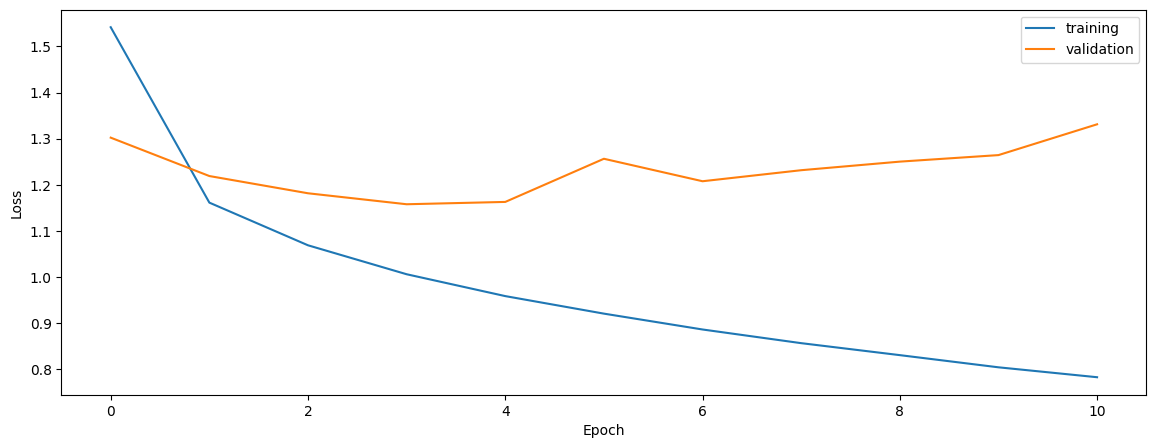

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.621933284280173
0.5594622370786823
0.5516448490683317


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5915248883390891
0.5534766338873901
0.5255825054446732


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6057761732851985
0.563953488372093
0.5426642893530311


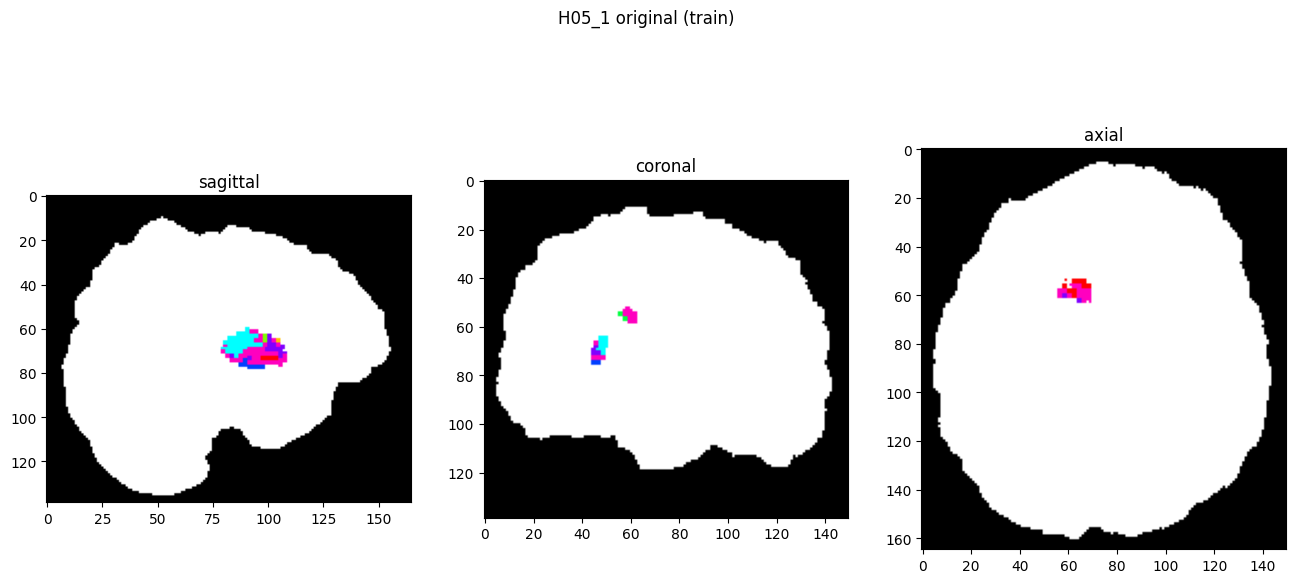

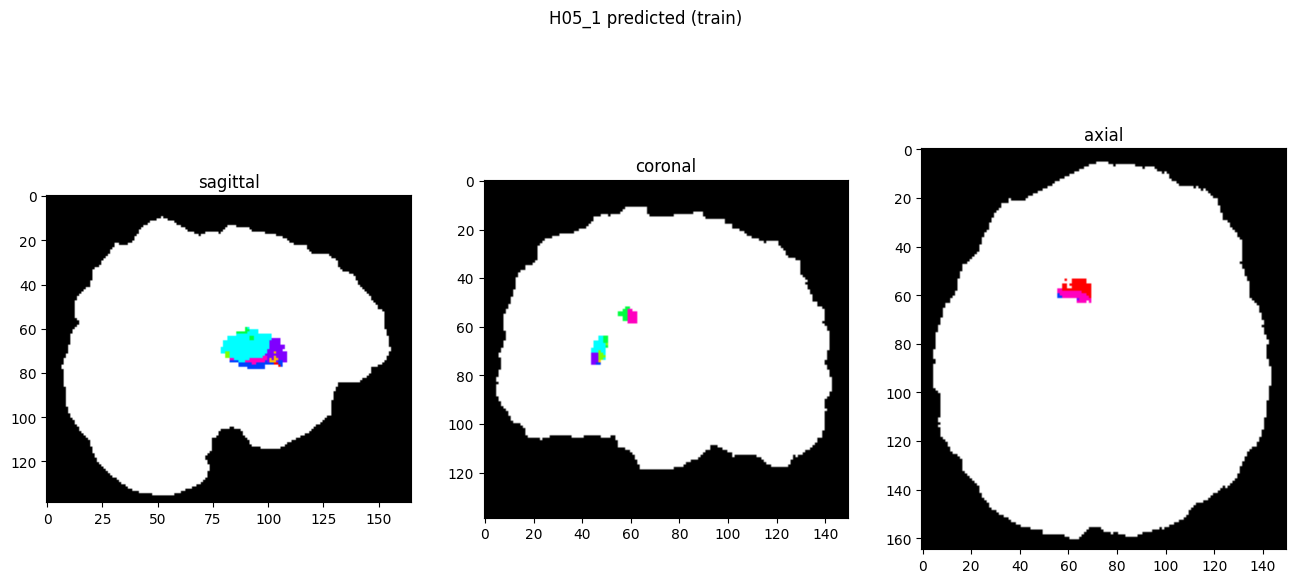

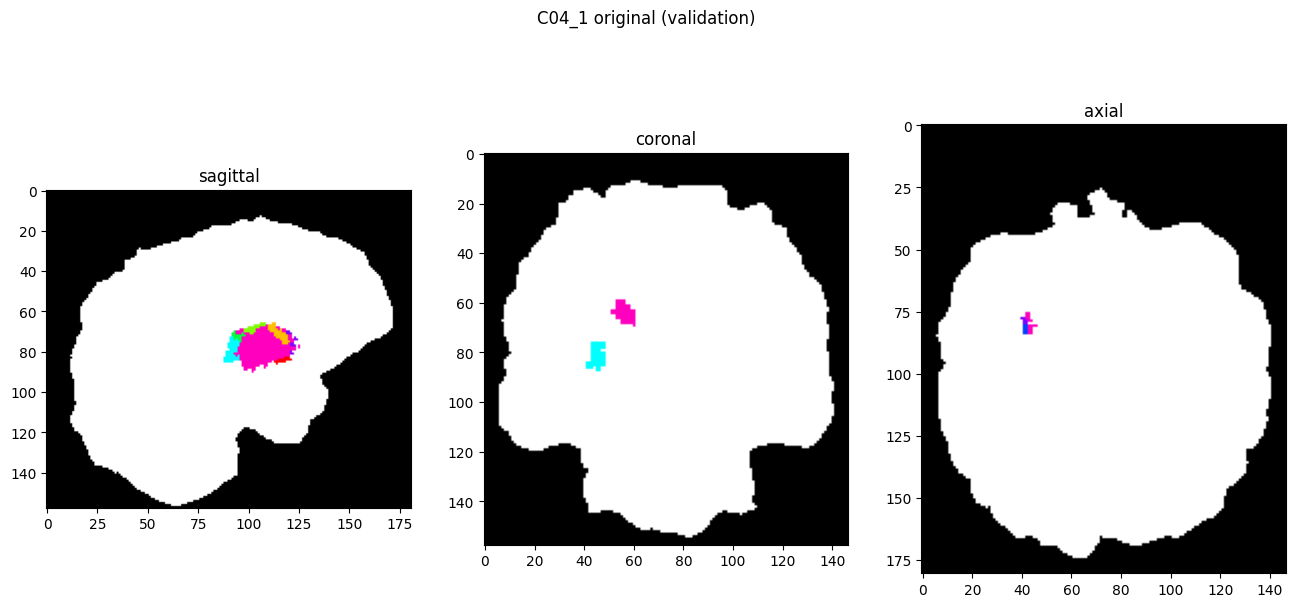

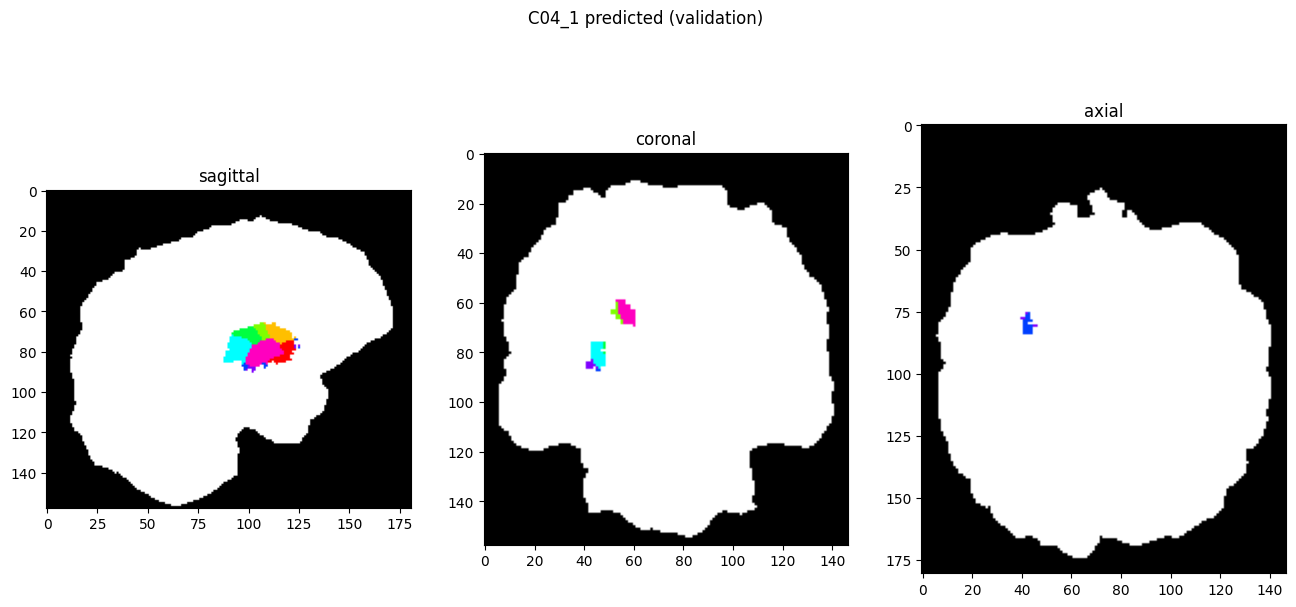

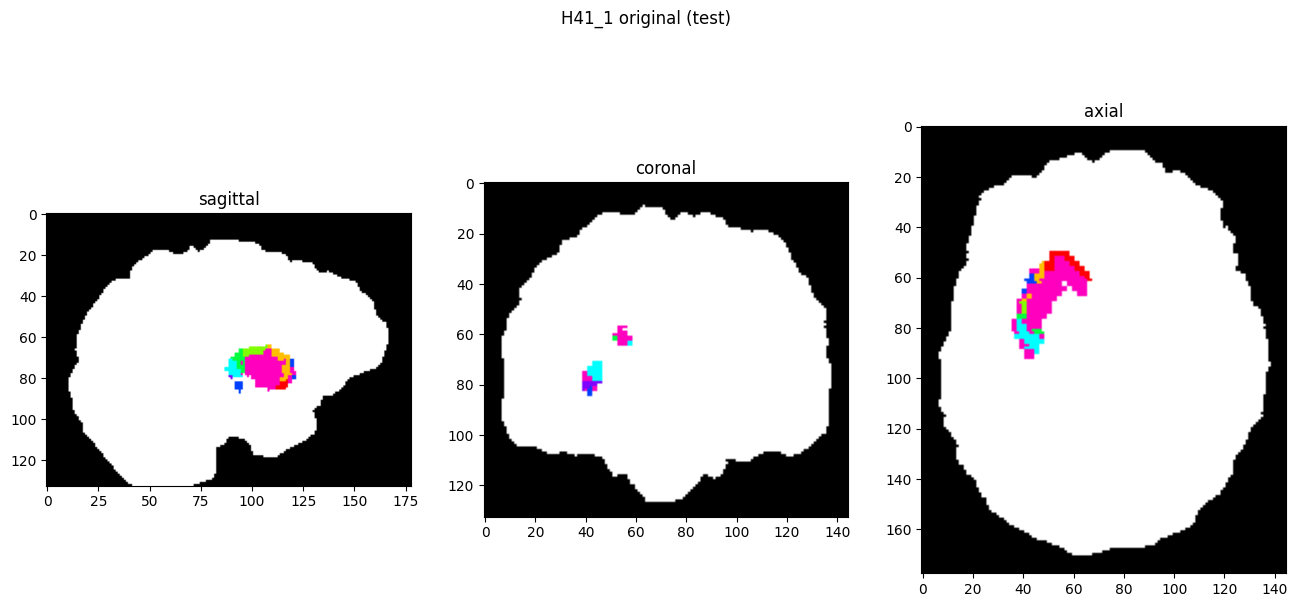

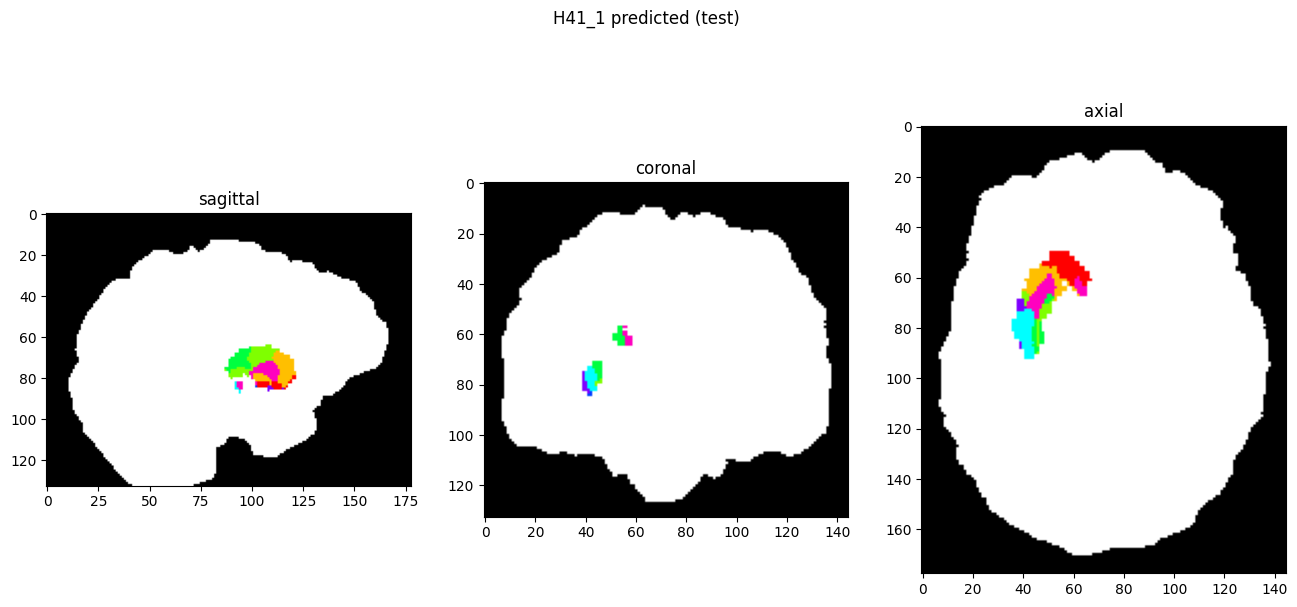

In [10]:
showResults(model, gen, threshold=0)